# Recurrent Neural Networks: Stability Analysis, Alignment, and LSTMs

## Complete Lecture Notes

---

**Course Context**: These notes cover the theory of recurrent neural networks, focusing on:
- Input-output structural variants
- Backpropagation through time (BPTT)
- The alignment problem in sequence-to-sequence learning
- Viterbi decoding and Connectionist Temporal Classification (CTC)

**Prerequisites**: Linear algebra, basic neural networks, familiarity with gradient-based optimization.

---

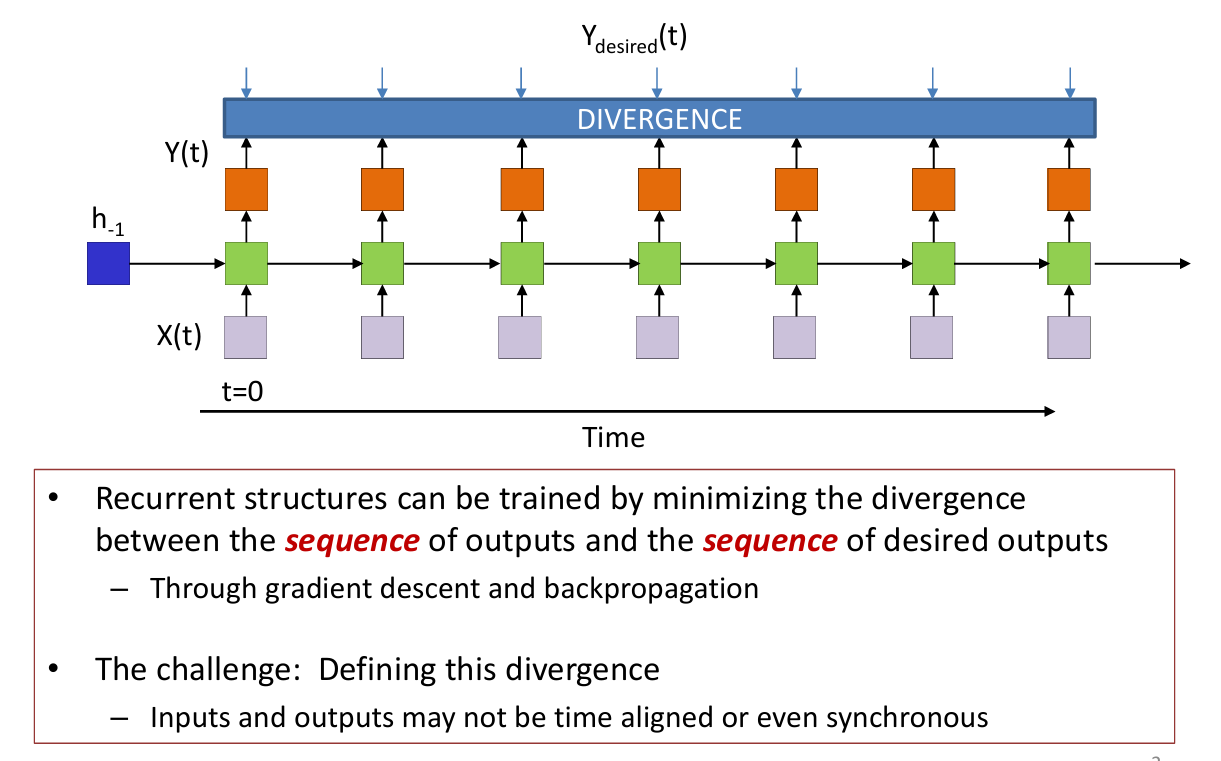

# Chapter 1: Variants of Neural Network Input-Output Structures

---

## 1.1 Motivation: Why Structural Variants Matter

Neural networks are fundamentally **function approximators**. The structure of this function depends critically on:

1. **Input structure**: Is the input a single vector or a sequence of vectors?
2. **Output structure**: Is the output a single prediction or a sequence of predictions?
3. **Temporal alignment**: How do inputs and outputs correspond in time?

> **Core Principle**: Before choosing an architecture (MLP, RNN, LSTM, Transformer), one must first understand the **input-output relationship** imposed by the problem.

This chapter establishes a taxonomy of sequence problems based on these structural constraints.

---

## 1.2 Taxonomy Based on Input-Output Cardinality

We classify neural network models based on the cardinality of inputs and outputs:

| Input | Output | Name | Notation |
|-------|--------|------|----------|
| Single vector | Single vector | One-to-One | $\mathbf{x} \rightarrow \mathbf{y}$ |
| Sequence | Single vector | Many-to-One | $(x_0, \ldots, x_T) \rightarrow \mathbf{y}$ |
| Single vector | Sequence | One-to-Many | $\mathbf{x} \rightarrow (y_0, \ldots, y_T)$ |
| Sequence | Sequence | Many-to-Many | $(x_0, \ldots, x_T) \rightarrow (y_0, \ldots, y_{T'})$ |

This classification is **orthogonal** to the choice of network architecture.

---

## 1.3 One-to-One: The Conventional MLP

### Definition

A one-to-one model maps a single input vector to a single output vector:

$$
\mathbf{y} = f(\mathbf{x}; \boldsymbol{\theta})
$$

### Properties

- No notion of time or sequential structure
- No internal state or memory
- Each input is processed independently

### Typical Applications

- Image classification (single image $\rightarrow$ class label)
- Tabular data prediction
- Static regression tasks

### Limitation

Even if inputs arrive sequentially, a standard MLP:
- Treats each time step **independently**
- Has **no temporal modeling capacity**

This fundamental limitation motivates recurrent architectures.

---

## 1.4 Many-to-One: Sequence to Single Output

### Definition

A many-to-one model processes an entire sequence and produces a single output:

$$
\mathbf{y} = f(x_0, x_1, \ldots, x_T)
$$

### Computational Interpretation

The model must **aggregate information across time** to produce a global summary. In RNNs, this is typically achieved by using only the **final hidden state**:

$$
\mathbf{y} = g(\mathbf{h}_T)
$$

where $\mathbf{h}_T$ encodes the entire input history.

### Typical Applications

- **Sentiment analysis**: sentence $\rightarrow$ sentiment label
- **Document classification**: text $\rightarrow$ category
- **Isolated word recognition**: acoustic sequence $\rightarrow$ word identity

### Training Implication

- Loss is defined **once per sequence** (at the end)
- Gradient signal must propagate backward through all time steps
- This leads to the problem of **sparse supervision**

---

## 1.5 One-to-Many: Single Input to Sequence Output

### Definition

A one-to-many model generates a sequence of outputs from a single input:

$$
y_t = f(\mathbf{h}_t), \quad \mathbf{h}_t = g(\mathbf{h}_{t-1}, \mathbf{x})
$$

### Computational Interpretation

The input $\mathbf{x}$ acts as:
- A **conditioning signal** or **context vector**
- A **seed** for generating an output sequence

Temporal dependency exists **only among outputs**; the input is static but influences all outputs through the initial hidden state.

### Typical Applications

- **Image captioning**: image $\rightarrow$ text description
- **Music generation**: theme/style $\rightarrow$ audio sequence
- **Text generation from prompt**: single prompt $\rightarrow$ paragraph

---

## 1.6 Many-to-Many: Sequence to Sequence

This is the **most general and practically important** case. It subdivides into two fundamentally different scenarios.

---

### 1.6.1 Time-Synchronous Many-to-Many

**Definition**: One output is produced for each input, with exact temporal alignment.

$$
y_t = f(x_t, \mathbf{h}_{t-1}) \quad \forall t \in \{0, 1, \ldots, T\}
$$

**Properties**:
- Input length equals output length: $|X| = |Y|$
- Strict one-to-one temporal correspondence
- Output at time $t$ corresponds exactly to input at time $t$

**Loss Function**:

$$
\mathcal{L} = \sum_{t=0}^{T} \ell(y_t, y_t^{*})
$$

where $y_t^{*}$ is the target at time $t$.

**Applications**:
- Part-of-speech tagging
- Named entity recognition
- Frame-level phoneme classification

This is the **simplest sequence-to-sequence setting** because alignment is known.

---

### 1.6.2 Order-Synchronous, Time-Asynchronous Many-to-Many

**Definition**: The output is a sequence, but the **timing of outputs is unknown**. Only the **order** of output symbols is preserved.

**Formal Setup**:
- Input sequence of length $N$: $(x_0, x_1, \ldots, x_{N-1})$
- Output symbol sequence of length $K \leq N$: $(s_0, s_1, \ldots, s_{K-1})$

**Critical Distinction**:
- **Order is preserved**: $s_i$ appears before $s_j$ if $i < j$
- **Time alignment is latent**: We do not know which input time step corresponds to which output symbol

**Why This Is Hard**:

The network outputs probabilities at every time step:

$$
y_t(i) = P(\text{symbol } i \mid x_0, \ldots, x_t)
$$

But we do not know:
- Which time $t$ corresponds to which symbol $s_i$
- Whether an output at time $t$ is a "real" emission or a repetition

This leads to:
- The **alignment problem**
- The need for **dynamic programming** (Viterbi, CTC)

**Applications**:
- Continuous speech recognition
- Handwriting recognition
- Any task where output symbols have unknown temporal boundaries

---

## 1.7 A Posteriori Sequence Generation (Encoder-Decoder)

### Definition

The entire input sequence is processed first, then the output sequence is generated:

$$
\text{Encoder}: X \rightarrow \mathbf{c}
$$
$$
\text{Decoder}: \mathbf{c} \rightarrow Y
$$

where $\mathbf{c}$ is a context vector summarizing the input.

### Properties

- No output until **all input is consumed**
- Input and output lengths are **decoupled**
- Often augmented with attention mechanisms

### Applications

- Machine translation
- Text summarization
- Question answering

---

## 1.8 Summary Table

| Variant | Input | Output | Time Alignment | Key Challenge | Example |
|---------|-------|--------|----------------|---------------|---------|
| One-to-One | Single | Single | N/A | None | Image classification |
| Many-to-One | Sequence | Single | End-only | Sparse supervision | Sentiment analysis |
| One-to-Many | Single | Sequence | Generated | Autoregressive generation | Image captioning |
| Many-to-Many (sync) | Sequence | Sequence | Exact | BPTT | POS tagging |
| Many-to-Many (async) | Sequence | Sequence | Unknown | Alignment, decoding | Speech recognition |
| Seq2Seq | Sequence | Sequence | Decoupled | Context bottleneck | Translation |

---

## 1.9 Why This Chapter Is Foundational

Everything that follows in these notes depends on understanding **which variant** applies:

| Topic | Depends On |
|-------|------------|
| BPTT derivation | Sync vs async outputs |
| Loss function design | Alignment assumption |
| Viterbi algorithm | Time-asynchronous case |
| CTC training | Unknown alignment |
| Gradient pathologies | Sequence length, supervision density |

> **Key Takeaway**: Before selecting an architecture, loss function, or training algorithm, you must first answer: *What is the temporal relationship between my inputs and outputs?*

---

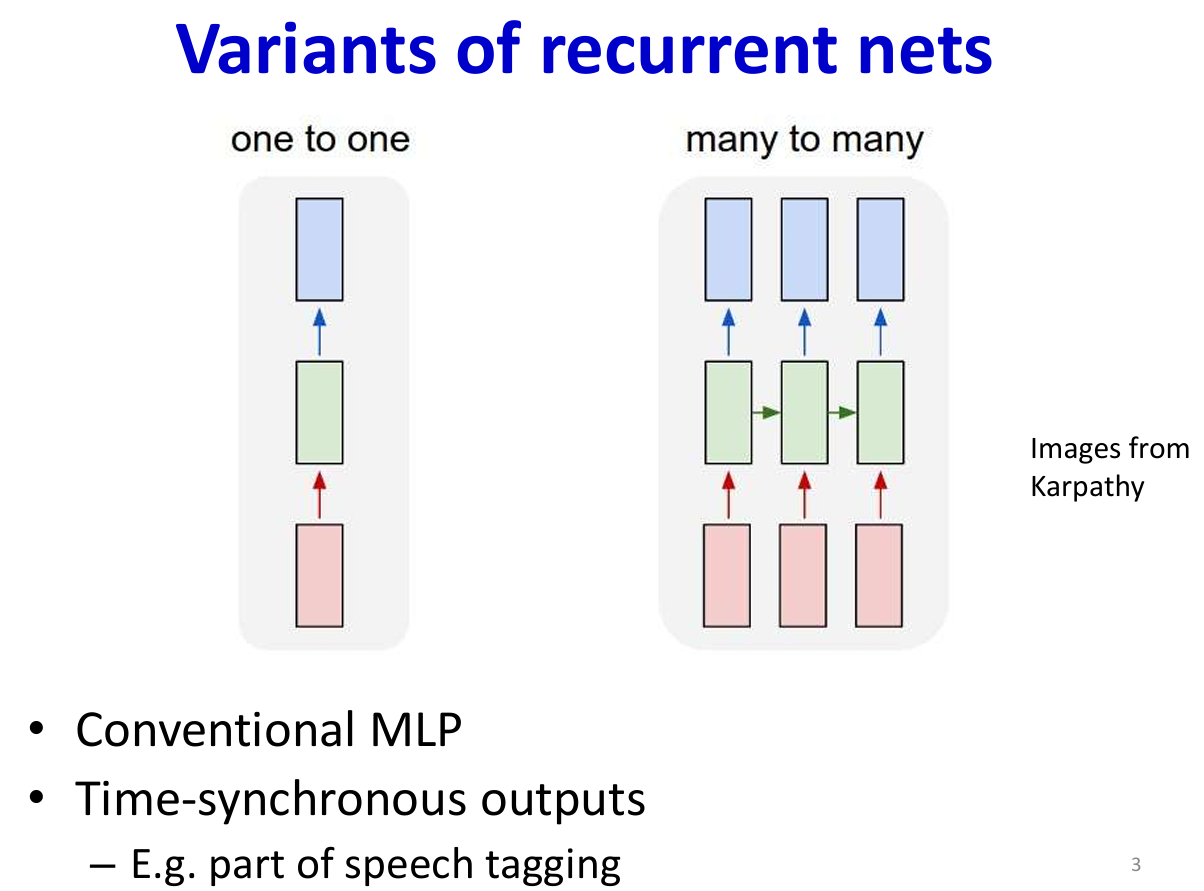

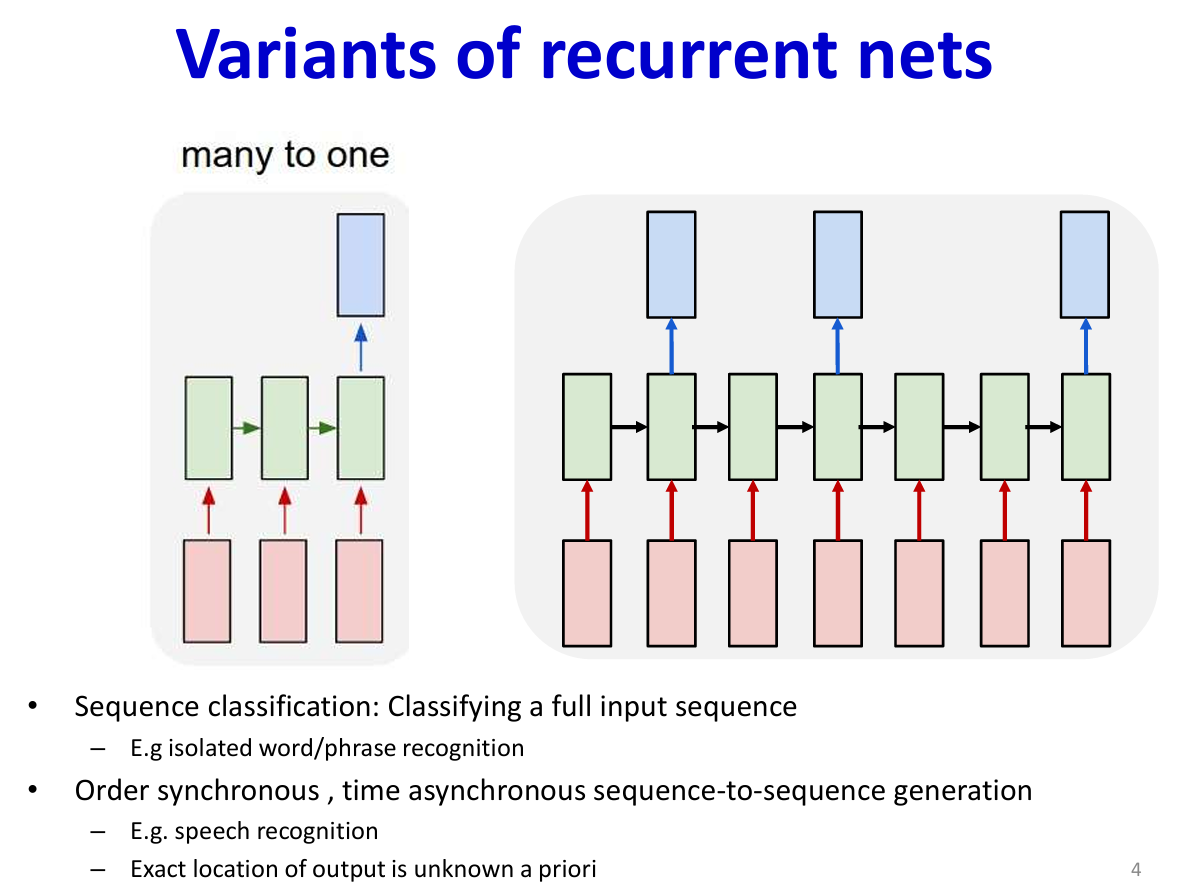

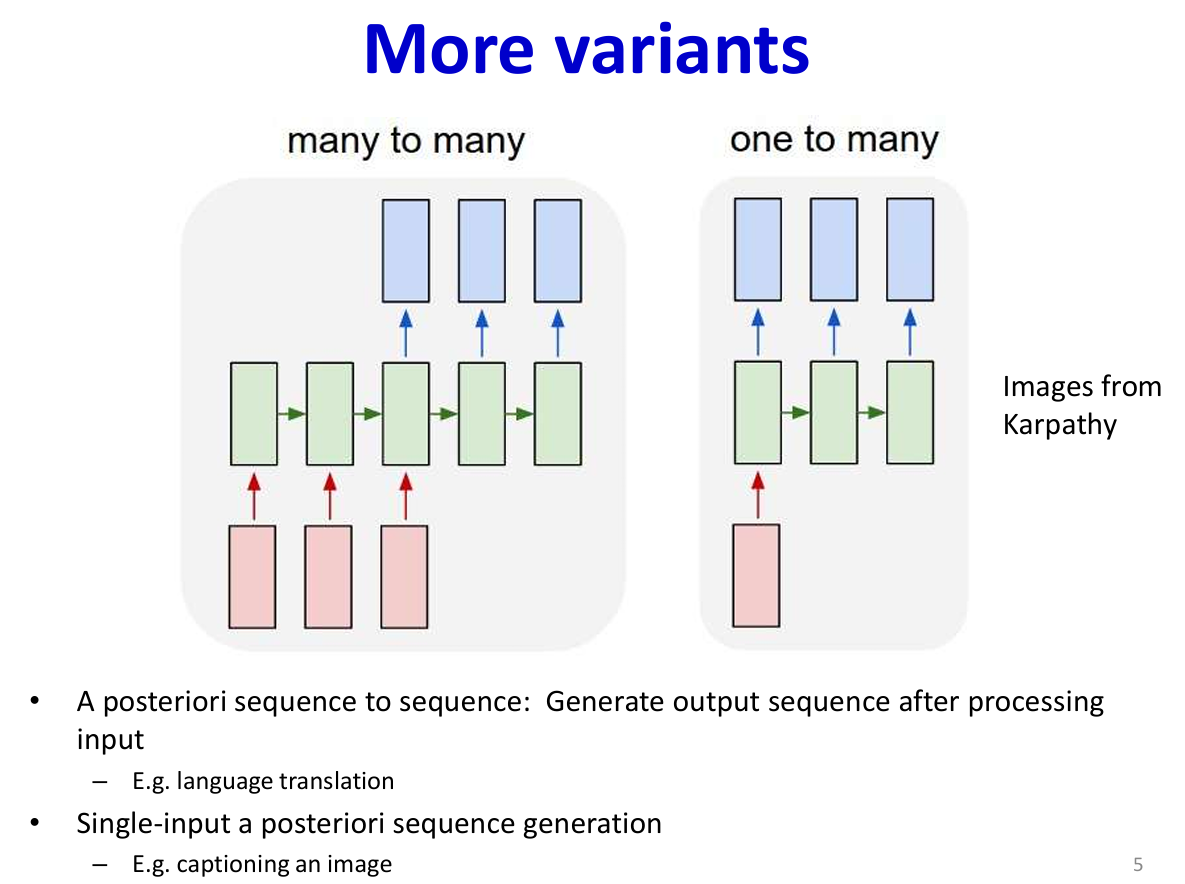

# Chapter 2: Conventional MLPs for Sequential Data

---

## 2.1 Motivation: Can MLPs Handle Sequences?

Before introducing recurrent architectures, a fundamental question arises:

> *Can a conventional multilayer perceptron (MLP) process sequential data at all?*

The answer is: **yes, but with severe limitations**.

This chapter establishes:
1. What MLPs can do with sequences
2. What they fundamentally **cannot** do
3. A baseline against which to compare recurrent models

---

## 2.2 The Structure of a Conventional MLP

A multilayer perceptron implements a **static, memoryless function**:

$$
\mathbf{y} = f(\mathbf{x}; \boldsymbol{\theta})
$$

**Key Characteristics**:
- No internal state
- No memory across inputs
- Each input is processed **independently**

If we apply an MLP to a sequence $(x_0, x_1, \ldots, x_T)$, what we actually compute is:

$$
y_t = f(x_t; \boldsymbol{\theta}) \quad \forall t
$$

Each time step is processed in complete isolation.

---

## 2.3 The "Series MLP" Formulation

### Setup

Given:
- Input sequence: $X = (x_0, x_1, \ldots, x_T)$
- Target output sequence: $Y^{*} = (y_0^{*}, y_1^{*}, \ldots, y_T^{*})$

The MLP computes:

$$
Y = (f(x_0), f(x_1), \ldots, f(x_T))
$$

This configuration is sometimes called a **"series MLP"** or **"parallel application of MLP over time"**.

> **Critical Warning**: This is **not** a recurrent model. The word "series" refers to applying the same function to a series of inputs, not to any temporal modeling.

---

## 2.4 Divergence for Sequences in an MLP

Since MLP outputs are independent across time, the **only way to incorporate sequence structure** is through the **loss function**.

### Fundamental Assumption (Important)

> The divergence between predicted and target sequences is the **sum of per-time-step divergences**:

$$
\text{Div}(Y^{*}_{0:T}, Y_{0:T}) = \sum_{t=0}^{T} \text{Div}(y_t^{*}, y_t)
$$

**Implications**:
- No temporal coupling in the model
- Only **additive coupling** in the objective
- The sequence structure is imposed **externally**, not learned **internally**

---

## 2.5 Gradient Computation in a Series MLP

Because of the additive decomposition of the loss:

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} = \sum_{t=0}^{T} \frac{\partial \ell(y_t^{*}, y_t)}{\partial \boldsymbol{\theta}}
$$

### Key Consequences

The gradient at time $t$ depends **only on**:
- The input $x_t$
- The target $y_t^{*}$
- The parameters $\boldsymbol{\theta}$

**There is**:
- No gradient flow across time
- No temporal credit assignment
- No learning of temporal dependencies

Each time step behaves as an **independent training sample**.

---

## 2.6 Standard Loss for Classification

For classification tasks, the standard choice is **cross-entropy** (equivalent to KL divergence for one-hot targets):

$$
\ell(y_t^{*}, y_t) = -\sum_{k} y_t^{*}(k) \log y_t(k)
$$

For the entire sequence:

$$
\mathcal{L} = \sum_{t=0}^{T} \left( -\sum_{k} y_t^{*}(k) \log y_t(k) \right)
$$

This is mathematically well-defined but **hides a critical limitation**: the model cannot use context from other time steps.

---

## 2.7 What "Sequence Modeling" Means Here

In a series MLP:

| Component | Knows About Sequence? |
|-----------|----------------------|
| Model architecture | No |
| Hidden representations | No |
| Loss function | Yes (sums over time) |
| Gradient computation | No (independent per time) |

> **Key Insight**: The temporal structure is imposed **externally** by the loss function, not learned **internally** by the model.

**The model has**:
- No memory
- No state
- No dependency between outputs at different times

---

## 2.8 When Is an MLP Sufficient?

A series MLP is appropriate **only if**:

> The correct output at time $t$ depends **exclusively** on the input at time $t$.

### Valid Applications

- Frame-wise image classification (independent frames)
- Pointwise sensor readings (IID assumption)
- Any setting where temporal context is provably irrelevant

### Invalid Applications (Where MLP Fails)

- Speech recognition (phoneme depends on acoustic context)
- Language modeling (next word depends on previous words)
- Any task with temporal dependencies

---

## 2.9 Fundamental Limitations of MLPs for Sequences

### 1. No Temporal Context

An MLP cannot answer:
- "What happened before?"
- "What is coming next?"
- "How does this relate to the previous input?"

### 2. No Variable-Length Dependency

An MLP cannot learn:
- Long-term dependencies
- Patterns spanning multiple time steps
- Delayed cause-effect relationships

### 3. No Sequence-Level Reasoning

An MLP cannot:
- Detect motifs or patterns across time
- Accumulate evidence
- Encode order information (permuting inputs has no effect on individual outputs)

---

## 2.10 Formal Comparison: Series MLP vs. RNN

| Aspect | Series MLP | Recurrent Network |
|--------|------------|-------------------|
| Sequence awareness | Loss function only | Model architecture |
| Memory | None | Hidden state $\mathbf{h}_t$ |
| $y_t$ depends on | $x_t$ only | $x_0, x_1, \ldots, x_t$ |
| Temporal coupling | None | Through recurrent weights |
| Credit assignment | Local to each $t$ | Through time (BPTT) |

---

## 2.11 Mathematical Formalization of the Limitation

Let $y_t^{\text{MLP}}$ and $y_t^{\text{RNN}}$ denote outputs from an MLP and RNN respectively.

**MLP**:
$$
y_t^{\text{MLP}} = f(x_t; \boldsymbol{\theta})
$$

**RNN**:
$$
y_t^{\text{RNN}} = g(\mathbf{h}_t; \boldsymbol{\theta}), \quad \mathbf{h}_t = \phi(x_t, \mathbf{h}_{t-1}; \boldsymbol{\theta})
$$

The RNN output $y_t^{\text{RNN}}$ is a function of **the entire history** $(x_0, x_1, \ldots, x_t)$ through the recurrent hidden state. The MLP output $y_t^{\text{MLP}}$ is a function of $x_t$ **alone**.

---

## 2.12 Why This Chapter Matters

Understanding this chapter is essential for answering:

1. *Why do we need recurrence?* Because MLPs cannot model temporal dependencies.
2. *What problem does BPTT solve?* It propagates gradients through time, which is unnecessary for MLPs.
3. *Why does alignment become an issue?* Because once we have temporal modeling, we must consider how outputs align with inputs.

> **Summary Statement**: A conventional MLP can process sequences only by treating time steps independently; any notion of "sequence" exists solely in the loss function, not in the model. This motivates the introduction of recurrent connections.

---

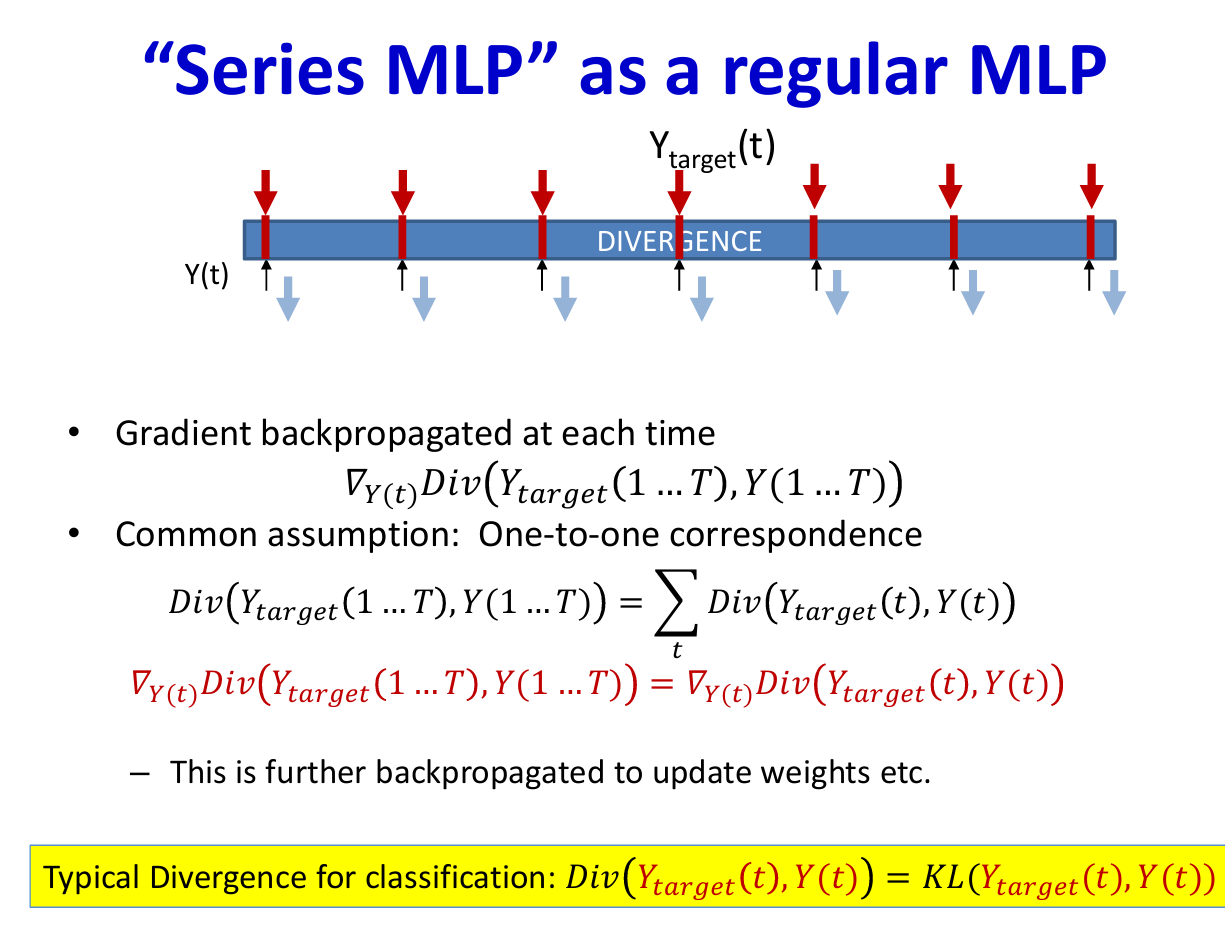

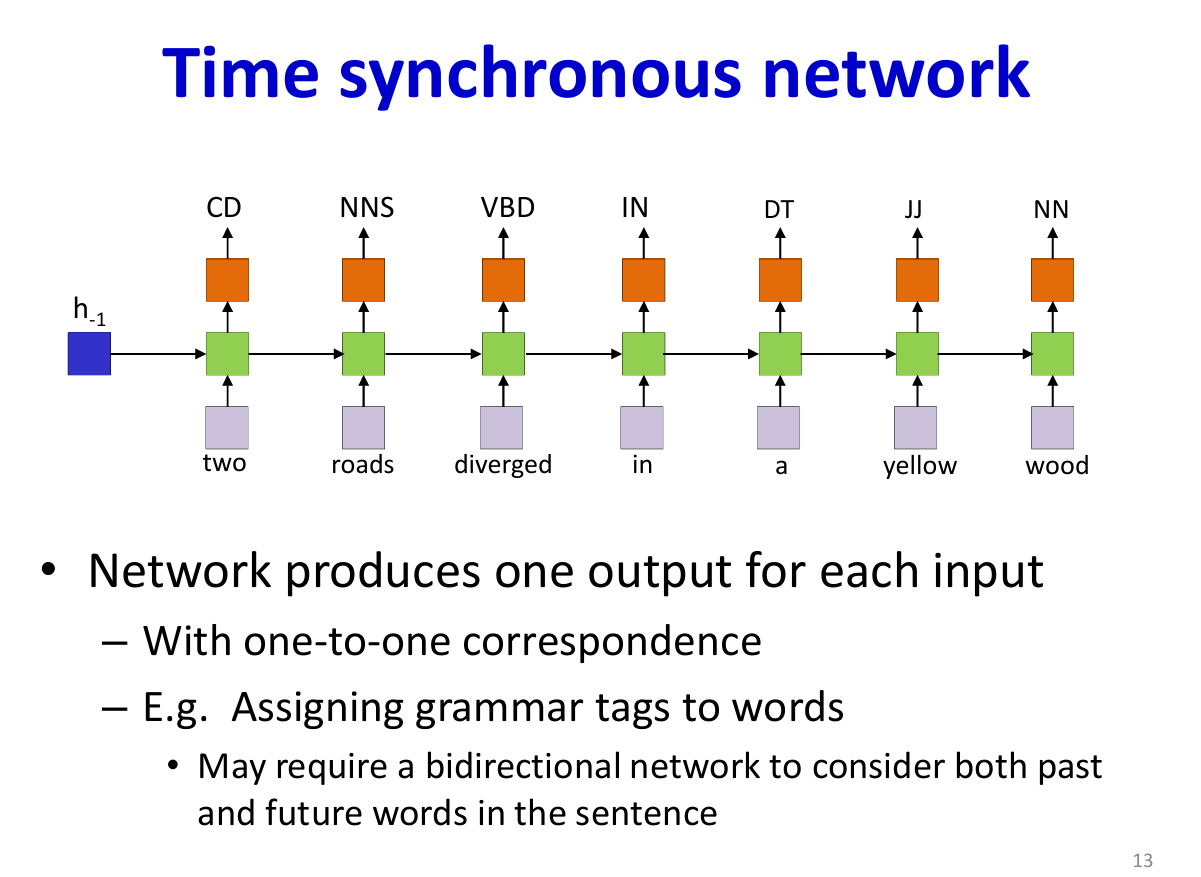

---

# Chapter 3: Time-Synchronous Recurrent Networks

---

## 3.1 Transition from MLPs: The Missing Ingredient

From Chapter 2, we established that MLPs:
- Can process sequences by treating each time step independently
- **Cannot** model temporal dependencies
- Have no mechanism to remember past inputs

The missing ingredient is:

> **State**: A representation that persists across time and carries information from the past into the present.

Time-synchronous recurrent networks introduce this state while maintaining the **simplest possible alignment assumption**.

---

## 3.2 Definition: Time-Synchronous Networks

A recurrent network is **time-synchronous** if:

> For every input vector at time $t$, the network produces **exactly one output** at the same time $t$.

**Formal Notation**:

$$
x_t \longrightarrow y_t \quad \forall t \in \{0, 1, \ldots, T\}
$$

**Implications**:
- Input length equals output length: $|X| = |Y| = T + 1$
- Exact one-to-one temporal correspondence
- No ambiguity about which output corresponds to which input

This assumption **dramatically simplifies** both training and inference.

---

## 3.3 Basic RNN Computational Structure

At each time step $t$, a recurrent neural network computes:

### Hidden State Update

$$
\mathbf{h}_t = \phi\left( \mathbf{W}_{xh} \mathbf{x}_t + \mathbf{W}_{hh} \mathbf{h}_{t-1} + \mathbf{b}_h \right)
$$

### Output Computation

$$
\mathbf{y}_t = \psi\left( \mathbf{W}_{hy} \mathbf{h}_t + \mathbf{b}_y \right)
$$

**Notation**:
- $\mathbf{h}_t \in \mathbb{R}^{d_h}$: hidden state (memory) at time $t$
- $\mathbf{x}_t \in \mathbb{R}^{d_x}$: input at time $t$
- $\mathbf{y}_t \in \mathbb{R}^{d_y}$: output at time $t$
- $\mathbf{W}_{xh} \in \mathbb{R}^{d_h \times d_x}$: input-to-hidden weights
- $\mathbf{W}_{hh} \in \mathbb{R}^{d_h \times d_h}$: hidden-to-hidden (recurrent) weights
- $\mathbf{W}_{hy} \in \mathbb{R}^{d_y \times d_h}$: hidden-to-output weights
- $\phi(\cdot)$: hidden activation (typically $\tanh$ or ReLU)
- $\psi(\cdot)$: output activation (softmax for classification, linear for regression)

### Initial Condition

The hidden state is initialized, typically as:

$$
\mathbf{h}_{-1} = \mathbf{0}
$$

or learned as a parameter.

---

## 3.4 The Hidden State as Compressed History

The hidden state $\mathbf{h}_t$ serves as the network's **memory**. It:

- Summarizes all past inputs $(x_0, x_1, \ldots, x_t)$
- Is a **learned, compressed representation** of history
- Is the **only mechanism** through which past information influences the present

**Mathematically**, unrolling the recursion:

$$
\mathbf{h}_t = f(x_t, x_{t-1}, \ldots, x_0; \boldsymbol{\theta})
$$

The network is free to decide **what to remember** and **what to forget**. No explicit rule enforces which information is retained.

> **Key Insight**: The hidden state is a **sufficient statistic** for prediction, given the model's capacity. All relevant history must be encoded in $\mathbf{h}_t$.

---

## 3.5 Comparison: Series MLP vs. Time-Synchronous RNN

| Aspect | Series MLP | Time-Synchronous RNN |
|--------|------------|----------------------|
| Memory | None | Hidden state $\mathbf{h}_t$ |
| Output $y_t$ depends on | $x_t$ only | $x_0, x_1, \ldots, x_t$ |
| Temporal coupling | None | Through $\mathbf{W}_{hh}$ |
| Sequence modeling | External (loss only) | Internal (architecture) |
| Credit assignment | Local | Through time (BPTT) |
| Parameter sharing | Across independent instances | Across time steps |

---

## 3.6 Unidirectional vs. Bidirectional RNNs

### Unidirectional RNN

Processes inputs in a single direction (typically left-to-right):

$$
\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1})
$$

**Uses**: Past context only. Output at time $t$ cannot depend on inputs at times $t+1, t+2, \ldots$

### Bidirectional RNN

Processes inputs in **both directions**:

**Forward pass**:
$$
\overrightarrow{\mathbf{h}}_t = f(\mathbf{x}_t, \overrightarrow{\mathbf{h}}_{t-1})
$$

**Backward pass**:
$$
\overleftarrow{\mathbf{h}}_t = f(\mathbf{x}_t, \overleftarrow{\mathbf{h}}_{t+1})
$$

**Combined representation**:
$$
\mathbf{h}_t = \left[ \overrightarrow{\mathbf{h}}_t ; \overleftarrow{\mathbf{h}}_t \right]
$$

where $[\cdot ; \cdot]$ denotes concatenation.

**Uses**: Both past and future context.

> **Important Constraint**: Bidirectional models are **not causal**. They cannot be used for:
> - Real-time streaming applications
> - Online prediction where future inputs are unavailable

---

## 3.7 Training Objective for Time-Synchronous RNNs

Given:
- Input sequence: $X = (x_0, x_1, \ldots, x_T)$
- Target sequence: $Y^{*} = (y_0^{*}, y_1^{*}, \ldots, y_T^{*})$

The loss function is:

$$
\mathcal{L} = \sum_{t=0}^{T} \ell(y_t, y_t^{*})
$$

This has the **same form** as Chapter 2, but with a crucial difference:

> **Now $y_t$ depends on all previous inputs** through the hidden state recurrence.

The gradient computation must account for this dependency, leading to **Backpropagation Through Time (BPTT)**.

---

## 3.8 Why BPTT Is Required

Consider the dependency structure:

$$
y_t \rightarrow \mathbf{h}_t \rightarrow \mathbf{h}_{t-1} \rightarrow \cdots \rightarrow \mathbf{h}_0
$$

The loss at time $t$ depends on:
- The output $y_t$
- The hidden state $\mathbf{h}_t$
- All previous hidden states $\mathbf{h}_{t-1}, \ldots, \mathbf{h}_0$

Therefore, the gradient of the loss at time $t$ with respect to any parameter:
- Affects weights used at **earlier time steps**
- Must propagate through the entire recurrent chain

> **Consequence**: Standard backpropagation is insufficient. We must **unroll the network in time** and treat it as a deep feedforward network with shared weights.

This is the subject of Chapter 4.

---

## 3.9 Typical Applications

Time-synchronous RNNs are used when:
1. Output sequence length equals input sequence length
2. Each input has a corresponding known label
3. Temporal alignment is given

### Examples

| Task | Input | Output |
|------|-------|--------|
| Part-of-speech tagging | Word sequence | Tag sequence |
| Named entity recognition | Token sequence | Entity labels |
| Frame-level speech labeling | Acoustic frames | Phoneme labels per frame |
| Video classification | Frame sequence | Per-frame class labels |

---

## 3.10 Inference in Time-Synchronous RNNs

During inference:

1. Initialize $\mathbf{h}_{-1} = \mathbf{0}$
2. For each time step $t = 0, 1, \ldots, T$:
   - Compute $\mathbf{h}_t = \phi(\mathbf{W}_{xh}\mathbf{x}_t + \mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h)$
   - Compute $\mathbf{y}_t = \psi(\mathbf{W}_{hy}\mathbf{h}_t + \mathbf{b}_y)$
   - Emit output $\mathbf{y}_t$

For unidirectional models:
- Processing is **online**: output is available immediately at each time step
- Enables **low-latency** applications

---

## 3.11 Key Assumptions in Time-Synchronous RNNs

1. **One output per input**: $|Y| = |X|$
2. **Exact time alignment**: Output $y_t$ corresponds to input $x_t$
3. **Additive loss decomposition**: $\mathcal{L} = \sum_t \ell_t$
4. **Dense supervision**: Loss is defined at every time step

These assumptions **will be relaxed** in later chapters, introducing significant complexity.

---

## 3.12 Summary

> **A time-synchronous RNN extends the conventional MLP by introducing a hidden state that carries information across time, allowing each output to depend on the entire past while preserving a strict one-to-one alignment between inputs and outputs.**

This chapter represents the **last "simple" case**:
- No alignment ambiguity
- No decoding problem
- No dynamic programming required

The next chapters address:
- How to train these networks (BPTT)
- What happens when supervision is sparse
- What happens when alignment is unknown

---

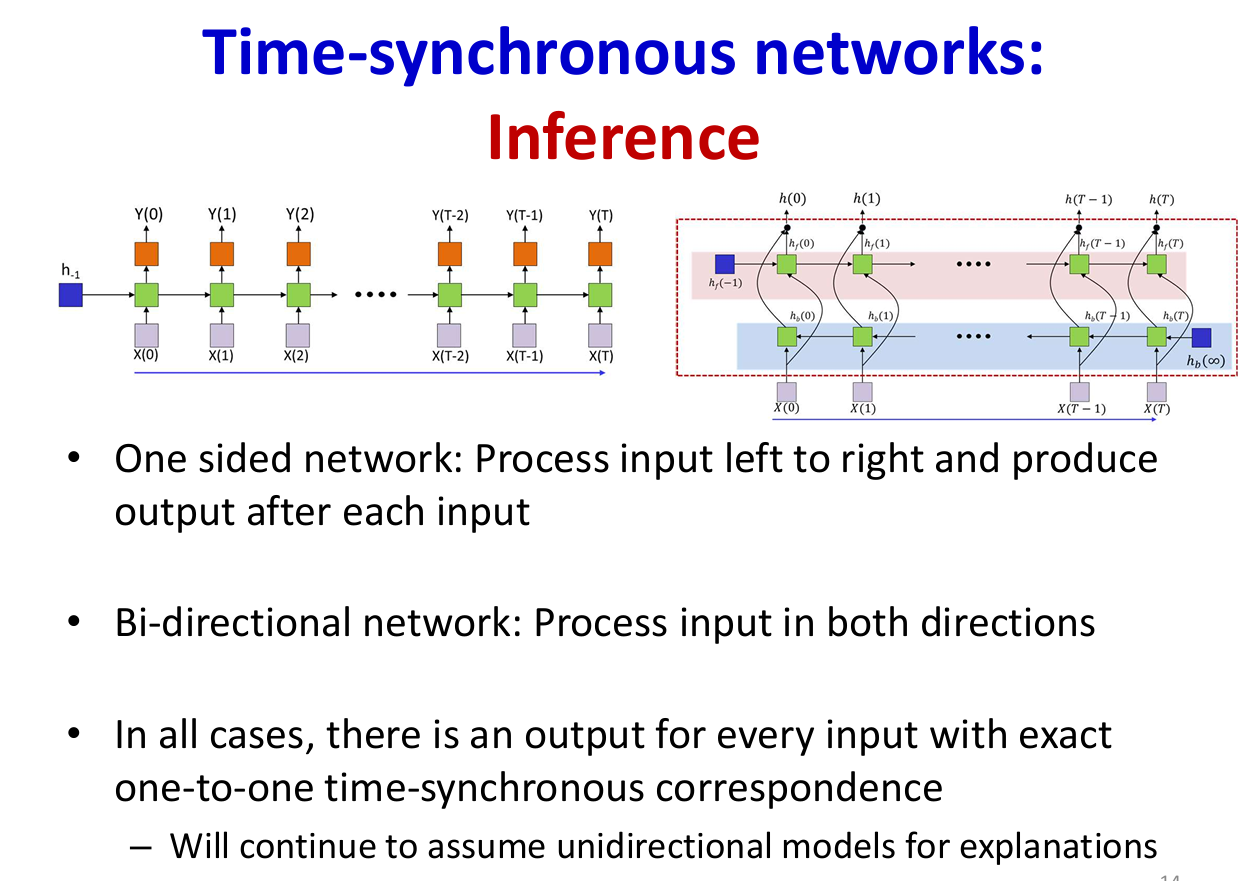

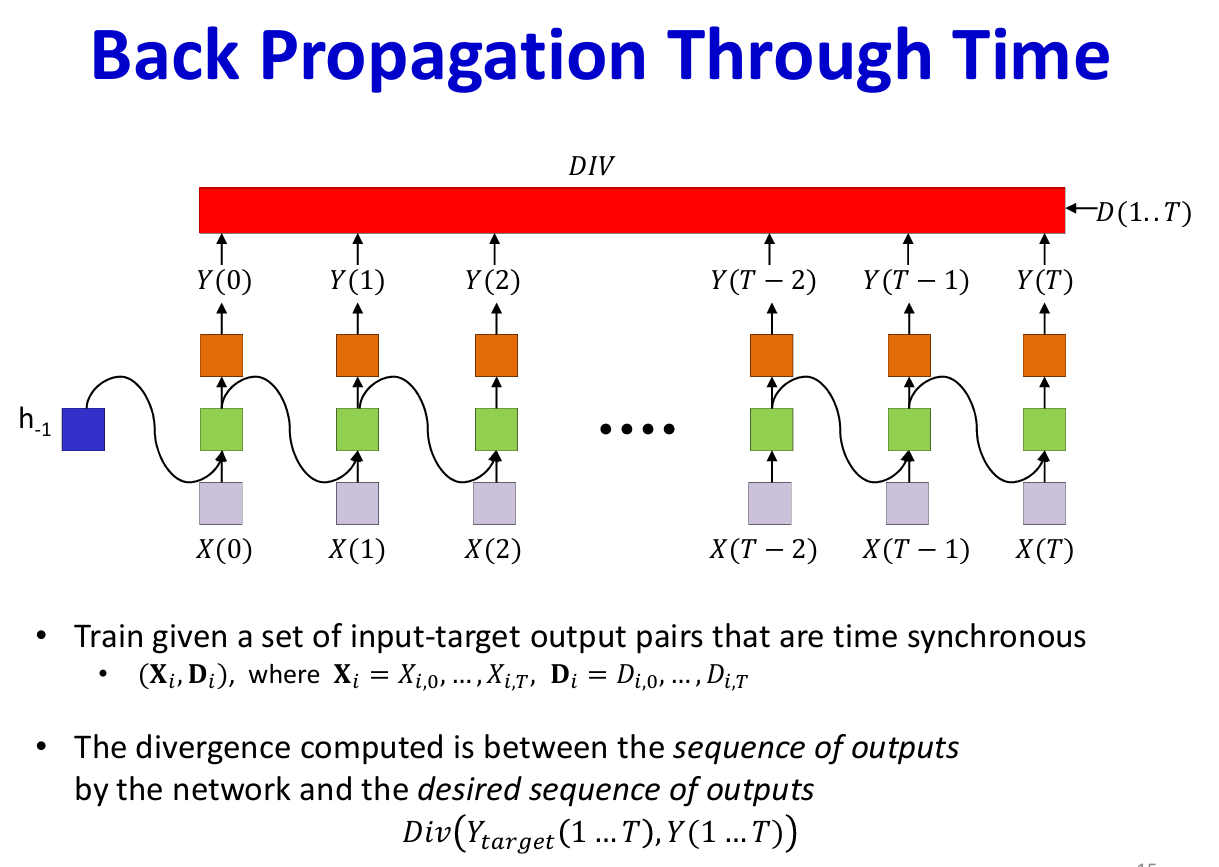

# Chapter 4-5: Backpropagation Through Time and Sequence Classification

---

## Part I: Backpropagation Through Time (BPTT)

---

## 4.1 Context: The Training Problem

From Chapter 3, we have:
- A time-synchronous RNN architecture
- Hidden states that depend on the entire input history
- A loss function summed over time steps

**The Training Question**: How do we compute gradients for parameters that are shared across time and influence outputs through a chain of recurrent connections?

---

## 4.2 Why Standard Backpropagation Is Insufficient

In an RNN, the hidden state recurrence creates **cycles** in the computational graph:

$$
\mathbf{h}_t = \phi(\mathbf{W}_{xh}\mathbf{x}_t + \mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h)
$$

The parameter $\mathbf{W}_{hh}$ appears at **every time step**. Its gradient involves:
- Direct effect at time $t$
- Indirect effects through $\mathbf{h}_{t-1}, \mathbf{h}_{t-2}, \ldots$

Standard backpropagation for feedforward networks does not handle this recurrence directly.

---

## 4.3 The Core Idea of BPTT

> **Unroll the RNN across time and treat it as a deep feedforward network with shared weights.**

For a sequence of length $T$:

$$
\mathbf{h}_0 \rightarrow \mathbf{h}_1 \rightarrow \cdots \rightarrow \mathbf{h}_T
$$

**Conceptual Mapping**:
- Each time step becomes a **layer**
- Depth of the unrolled network = sequence length $T$
- Parameters $\mathbf{W}_{xh}, \mathbf{W}_{hh}, \mathbf{W}_{hy}$ are **tied (shared)** across all layers

This transformation eliminates the cycle, enabling standard backpropagation on the unrolled graph.

---

## 4.4 Loss Definition for Dense Supervision

Given:
- Inputs: $(x_0, x_1, \ldots, x_T)$
- Outputs: $(y_0, y_1, \ldots, y_T)$
- Targets: $(y_0^{*}, y_1^{*}, \ldots, y_T^{*})$

The loss is:

$$
\mathcal{L} = \sum_{t=0}^{T} \ell_t, \quad \text{where } \ell_t = \ell(y_t, y_t^{*})
$$

This is **dense supervision**: every time step contributes to the loss, providing strong gradient signal throughout the sequence.

---

## 4.5 Gradient Flow Through Time: The BPTT Equations

### Defining the Error Signal

Let $\delta_t$ denote the gradient of the total loss with respect to the hidden state at time $t$:

$$
\delta_t = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t}
$$

### The Backward Recursion

By the chain rule:

$$
\delta_t = \frac{\partial \ell_t}{\partial \mathbf{h}_t} + \delta_{t+1} \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t}
$$

**Interpretation**:
- **First term**: Direct contribution from the local loss at time $t$
- **Second term**: Contributions from **all future losses** propagated backward through the recurrence

### Explicit Form

For the standard RNN with $\mathbf{h}_t = \phi(\mathbf{W}_{xh}\mathbf{x}_t + \mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h)$:

$$
\frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} = \text{diag}\left(\phi'(\mathbf{z}_{t+1})\right) \mathbf{W}_{hh}
$$

where $\mathbf{z}_{t+1} = \mathbf{W}_{xh}\mathbf{x}_{t+1} + \mathbf{W}_{hh}\mathbf{h}_t + \mathbf{b}_h$ is the pre-activation.

### Boundary Condition

At the final time step $T$:

$$
\delta_T = \frac{\partial \ell_T}{\partial \mathbf{h}_T}
$$

(No future errors to propagate.)

---

## 4.6 Parameter Gradients Under BPTT

Because parameters are shared across time, the total gradient is a **sum over all time steps**:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{hh}} = \sum_{t=0}^{T} \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_{hh}}\bigg|_{\text{local}}
$$

Similarly for $\mathbf{W}_{xh}$, $\mathbf{W}_{hy}$, and biases.

**Each parameter receives gradient contributions from every time step where it is used.**

---

## 4.7 BPTT Algorithm Summary

**Forward Pass**:
1. Initialize $\mathbf{h}_{-1} = \mathbf{0}$
2. For $t = 0$ to $T$:
   - Compute $\mathbf{h}_t = \phi(\mathbf{W}_{xh}\mathbf{x}_t + \mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h)$
   - Compute $\mathbf{y}_t = \psi(\mathbf{W}_{hy}\mathbf{h}_t + \mathbf{b}_y)$
   - Store $\mathbf{h}_t$ for backward pass
3. Compute $\mathcal{L} = \sum_{t=0}^{T} \ell(y_t, y_t^{*})$

**Backward Pass**:
1. Initialize $\delta_{T+1} = \mathbf{0}$
2. For $t = T$ down to $0$:
   - Compute $\delta_t = \frac{\partial \ell_t}{\partial \mathbf{h}_t} + \delta_{t+1} \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t}$
   - Accumulate gradients for $\mathbf{W}_{hh}, \mathbf{W}_{xh}, \mathbf{W}_{hy}, \mathbf{b}_h, \mathbf{b}_y$

---

## 4.8 Computational Complexity

| Resource | Complexity |
|----------|------------|
| Time (forward) | $O(T)$ |
| Time (backward) | $O(T)$ |
| Memory | $O(T)$ (must store all hidden states) |

**Memory is the key bottleneck**: For long sequences, storing all hidden states can be prohibitive.

---

## 4.9 Truncated BPTT

To manage memory and computation for long sequences, **Truncated BPTT** limits backward propagation to $k$ steps:

$$
\delta_t = \frac{\partial \ell_t}{\partial \mathbf{h}_t} + \sum_{\tau=t+1}^{\min(t+k, T)} \delta_{\tau} \frac{\partial \mathbf{h}_{\tau}}{\partial \mathbf{h}_t}
$$

**Trade-off**:
- Reduces memory to $O(k)$
- Cannot learn dependencies longer than $k$ steps
- Introduces bias in gradient estimation

---

## Part II: Sequence Classification (Many-to-One)

---

## 5.1 Transition: What Changes?

Up to now, we have assumed **dense supervision**: loss at every time step.

In **sequence classification**, this changes fundamentally:
- Input: Full sequence $(x_0, x_1, \ldots, x_T)$
- Output: **Single label** $\mathbf{y}$
- Loss: Defined **only at the end**

---

## 5.2 Problem Definition

### Setup
- Input sequence: $(x_0, x_1, \ldots, x_T)$
- Target: Single label $y^{*}$ (e.g., sentiment, word identity, class)
- Model output: $\mathbf{y} = g(\mathbf{h}_T)$

### Examples
- Sentiment analysis: sentence $\rightarrow$ positive/negative
- Isolated word recognition: acoustic sequence $\rightarrow$ word
- Document classification: text $\rightarrow$ topic

---

## 5.3 What the RNN Still Computes

Even though we want a single output, the RNN still computes at every time step:

$$
\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}), \quad \mathbf{y}_t = g(\mathbf{h}_t) \quad \forall t
$$

> **Key Point**: The network produces outputs at every time step, but we choose to **use only the final one** for the loss.

---

## 5.4 Loss Definition: Sparse Supervision

$$
\mathcal{L} = \ell(\mathbf{y}_T, y^{*})
$$

**No losses at intermediate time steps**:

$$
\ell_t = 0 \quad \text{for } t = 0, 1, \ldots, T-1
$$

This is called **sparse supervision** or **end-only supervision**.

---

## 5.5 Gradient Flow Under Sparse Supervision

Even though loss is defined only at $T$:
- $\frac{\partial \mathcal{L}}{\partial \mathbf{h}_T} \neq 0$
- Gradients still propagate backward via BPTT

The backward recursion becomes:

$$
\delta_t = \delta_{t+1} \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t}
$$

with $\delta_T = \frac{\partial \ell_T}{\partial \mathbf{h}_T}$ and $\frac{\partial \ell_t}{\partial \mathbf{h}_t} = 0$ for $t < T$.

**All inputs still influence learning**, but only through a **single loss signal** at the end.

---

## 5.6 The Core Difficulty: Weak Gradient Signal

### Comparison

| Aspect | Time-Synchronous (Dense) | Sequence Classification (Sparse) |
|--------|--------------------------|----------------------------------|
| Loss locations | Every time step | Final time step only |
| Supervision | Dense | Sparse |
| Gradient at early times | Strong (direct + propagated) | Weak (propagated only) |
| Training stability | Higher | Lower |

### Consequence

For long sequences:
- Gradients must travel through many time steps
- Subject to **vanishing/exploding gradient** problems
- Early inputs may have negligible influence on learning

---

## 5.7 The Vanishing Gradient Problem (Detailed)

Consider the gradient of the loss with respect to $\mathbf{h}_0$:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{h}_0} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_T} \prod_{t=1}^{T} \frac{\partial \mathbf{h}_t}{\partial \mathbf{h}_{t-1}}
$$

Each factor $\frac{\partial \mathbf{h}_t}{\partial \mathbf{h}_{t-1}} = \text{diag}(\phi'(\mathbf{z}_t)) \mathbf{W}_{hh}$.

**The product of $T$ matrices** can:
- **Vanish** if $\|\mathbf{W}_{hh}\| < 1$ (eigenvalues less than 1)
- **Explode** if $\|\mathbf{W}_{hh}\| > 1$ (eigenvalues greater than 1)

For $\tanh$ activation, $|\phi'(z)| \leq 1$, compounding the vanishing effect.

> **Implication**: Information from early time steps has exponentially diminishing influence on the loss as sequence length increases.

---

## 5.8 Practical Mitigation: Weighted Loss Over Time

A common fix is to apply loss at multiple time steps with weights:

$$
\mathcal{L} = \sum_{t=0}^{T} w_t \cdot \ell(\mathbf{y}_t, y^{*})
$$

where $w_t \geq 0$ and typically $w_T$ is largest.

**Examples**:
- Uniform weighting: $w_t = \frac{1}{T+1}$
- Exponential ramp: $w_t = \alpha^{T-t}$ for some $\alpha < 1$
- Pure sequence classification: $w_T = 1$, $w_t = 0$ for $t < T$

This provides **intermediate supervision**, strengthening gradients at early times.

---

## 5.9 Conceptual Unification of Chapters 4 and 5

> **Chapter 4 explains how gradients flow through time.**

> **Chapter 5 shows what happens when we starve that flow of supervision.**

Together, they explain:
1. Why long-term dependencies are hard to learn
2. Why vanishing gradients are a fundamental problem
3. Why architectures like LSTMs and GRUs were developed
4. Why alignment and decoding become necessary for certain problems

---

## 5.10 Summary

> **Backpropagation Through Time (BPTT) enables learning in recurrent networks by propagating errors backward across time. When supervision is provided only at the end of a sequence (sequence classification), the learning signal becomes sparse, making training harder and motivating richer loss definitions, regularization techniques, and architectures designed to preserve gradient flow (LSTMs, GRUs).**

---

## Key Equations Summary

| Equation | Description |
|----------|-------------|
| $\delta_t = \frac{\partial \ell_t}{\partial \mathbf{h}_t} + \delta_{t+1} \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t}$ | BPTT backward recursion |
| $\frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} = \text{diag}(\phi'(\mathbf{z}_{t+1})) \mathbf{W}_{hh}$ | Jacobian of recurrence |
| $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} = \sum_{t} \frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}}\big|_t$ | Total gradient (parameter sharing) |
| $\mathcal{L}_{\text{seq-class}} = \ell(\mathbf{y}_T, y^{*})$ | Sequence classification loss |

# Chapter 6: Order-Synchronous, Time-Asynchronous Sequence-to-Sequence Models

---

## 6.1 Motivation: Beyond Known Alignment

From Chapters 3-5, we worked with scenarios where:
- Time-synchronous: one output per input, alignment known
- Sequence classification: one output total, timing known (at the end)

Now we encounter the **most challenging and realistic setting**:

> The output is a **sequence of symbols**, but we do **not know when each symbol occurs** in time.

This breaks the fundamental assumptions used so far.

---

## 6.2 Formal Problem Definition

### Inputs

A sequence of $N$ feature vectors:

$$
X = (x_0, x_1, \ldots, x_{N-1})
$$

### Outputs

A **shorter sequence** of $K$ symbols ($K \leq N$):

$$
S = (s_0, s_1, \ldots, s_{K-1})
$$

### Critical Property

- The **order** of symbols is known: $s_0$ precedes $s_1$ precedes $\ldots$
- The **time alignment** is **unknown**: we do not know which input frame corresponds to which symbol

> **Terminology**: This is called **order-synchronous, time-asynchronous** because the symbol order is preserved, but their timing is latent.

---

## 6.3 Canonical Examples

### Speech Recognition

- **Input**: Sequence of acoustic feature frames (e.g., MFCCs), length $N$
- **Output**: Phoneme or character sequence, e.g., `/B/ /AH/ /T/`, length $K$
- **Unknown**: Which frames correspond to `/B/`? When does `/AH/` begin?

### Handwriting Recognition

- **Input**: Sequence of pen positions over time
- **Output**: Character sequence, e.g., "cat"
- **Unknown**: Where does 'c' end and 'a' begin?

### Optical Character Recognition (OCR)

- **Input**: Sequence of image columns
- **Output**: Text string
- **Unknown**: Character boundaries

---

## 6.4 What the Network Actually Outputs

At **every time step**, the RNN produces a **probability distribution** over symbols:

$$
y_t(i) = P(\text{symbol } i \mid x_0, x_1, \ldots, x_t)
$$

**Dimensions**:
- Input length: $N$
- Vocabulary size: $|\mathcal{A}|$ (number of possible symbols)
- Output matrix: $N \times |\mathcal{A}|$

The network outputs a **matrix of probabilities**, not a symbol sequence directly.

---

## 6.5 The Fundamental Mismatch

### What We Want

$$
\hat{S} = \arg\max_{S'} P(S' \mid X)
$$

That is, the **most likely symbol sequence** given the input.

### What We Get Directly

$$
P(s_t = i \mid X_{0:t}) \quad \text{for every } t \text{ and symbol } i
$$

**The network does NOT tell us**:
- Which time step corresponds to which symbol
- Which outputs are "real" emissions vs. transitions or repetitions
- How to map the $N \times |\mathcal{A}|$ matrix to a length-$K$ sequence

> **This is the core mismatch**: The network outputs **per-time distributions**, but we need a **sequence distribution**.

---

## 6.6 Why Naive Decoding Fails

### Naive Approach

At each time step, take the most likely symbol:

$$
\hat{s}_t = \arg\max_i y_t(i)
$$

Then collapse consecutive repetitions.

### Problems

1. **Ambiguity of repetitions**: Cannot distinguish between:
   - A single long symbol (e.g., holding `/AH/` for 5 frames)
   - Multiple occurrences of the same symbol (e.g., "AA" as in "aardvark")

2. **Does not maximize sequence probability**: Taking $\arg\max$ at each time step does **not** yield $\arg\max$ over sequences.

3. **Produces invalid sequences**: The collapsed output may not match any valid target.

### Example

Network outputs (most likely symbol per time):
```
/B/ /B/ /B/ /AH/ /AH/ /T/ /T/
```

Naive collapse yields: `/B/ /AH/ /T/`

But what if the target was `/B/ /B/ /AH/ /T/` (with two B's)?

The representation is ambiguous without additional structure.

---

## 6.7 Key Distinction: Two Types of Sequences

We must carefully distinguish:

### Time-Synchronous Sequence (Length $N$)

- One symbol per time step
- Same length as input
- Contains repetitions and "stay" symbols
- Example: `/B/ /B/ /B/ /AH/ /AH/ /T/`

### Order-Synchronous (Compressed) Sequence (Length $K$)

- Distinct symbols only
- Shorter than or equal to input length
- Example: `/B/ /AH/ /T/`

**Relationship**: The compressed sequence is obtained by removing consecutive duplicates from the time-synchronous sequence.

---

## 6.8 Alignment: The Missing Variable

An **alignment** is:

> A mapping from the compressed symbol sequence to a time-synchronous expanded sequence.

**Formally**: Given compressed sequence $S = (s_0, \ldots, s_{K-1})$, an alignment produces:

$$
\tilde{S} = (\tilde{s}_0, \tilde{s}_1, \ldots, \tilde{s}_{N-1})
$$

such that $\text{compress}(\tilde{S}) = S$.

### Example

$S = (/B/, /AH/, /T/)$ with $N = 6$ could have alignments:
- $\tilde{S}_1 = (/B/, /B/, /AH/, /AH/, /AH/, /T/)$
- $\tilde{S}_2 = (/B/, /AH/, /AH/, /T/, /T/, /T/)$
- $\tilde{S}_3 = (/B/, /B/, /B/, /AH/, /AH/, /T/)$
- ... (many more)

> **Key Insight**: There are **exponentially many** valid alignments for a given symbol sequence.

---

## 6.9 Why Training Becomes Ill-Defined

Training requires computing:

$$
\mathcal{L} = \text{Div}(Y^{*}, Y)
$$

But now:
- $Y^{*}$ (target) is a **compressed symbol sequence** with no time stamps
- $Y$ (network output) is a **per-time probability matrix**

> **Fundamental Problem**: We cannot directly compare these representations because they have different structures.

**Question**: Which $y_t$ should be compared with which $s_i$?

**Answer**: We don't know. The alignment is **latent**.

---

## 6.10 Two Possible Training Strategies

### Strategy 1: Estimate a Single Alignment

1. Start with an initial (possibly random) alignment
2. Treat it as ground truth: define per-time targets
3. Train the model using time-synchronous BPTT
4. Re-estimate alignment using trained model
5. Iterate

This resembles **EM-style training** or **hard alignment training**.

**Problems**:
- Commits to a single alignment, which may be wrong
- Early mistakes propagate and reinforce
- Local optima

---

### Strategy 2: Consider All Possible Alignments

Instead of choosing one alignment:
- **Sum** (or maximize) over all valid alignments
- Use dynamic programming to compute this efficiently

This is the **principled probabilistic approach**, leading to:
- **Viterbi decoding** (maximum over alignments)
- **CTC training** (sum over alignments)

---

## 6.11 Summary of New Concepts Introduced

| Concept | Status in Chapter 6 |
|---------|---------------------|
| Multiple outputs (sequence) | Yes |
| Unknown timing | Yes |
| Alignment | Latent variable |
| Decoding | Required |
| Dynamic programming | Necessary |

---

## 6.12 Conceptual Summary

> **In order-synchronous, time-asynchronous sequence-to-sequence problems, the network outputs symbol probabilities at every time step, but the correct output symbols occur at unknown times. Training therefore requires either estimating or marginalizing over alignments between symbol sequences and input time steps.**

---

## 6.13 Logical Transition

We now need to answer:
1. How do we **represent** alignments mathematically?
2. How do we **score** an alignment?
3. How do we **find the best alignment** efficiently?

These questions lead directly to Chapter 7: Alignment, Expansion, Compression, and Decoding.

---

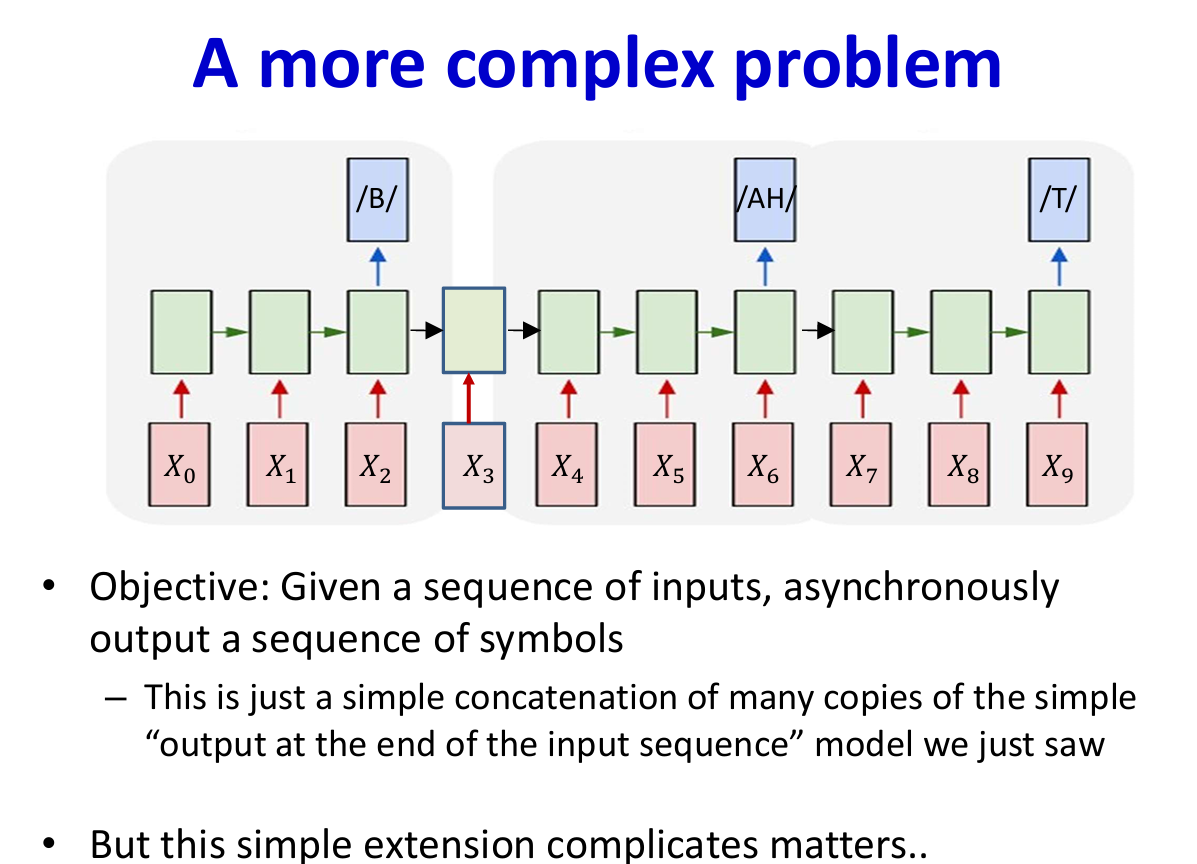 





# Chapter 7: Alignment, Expansion, Compression, and Decoding

---

## 7.1 Motivation: Making the Problem Tractable

From Chapter 6, we established the core difficulty:
- Network outputs probabilities at every time step
- Target is a shorter symbol sequence
- Timing is unknown

We cannot:
- Define a loss directly
- Train the network
- Decode outputs meaningfully

**This chapter introduces the mathematical machinery** needed to formalize and solve this problem:
- Precise definitions of alignment, expansion, compression
- Graph representation of alignments
- Foundation for efficient algorithms

---

## 7.2 Three Distinct Sequence Types

We must carefully distinguish three different sequence representations:

### 7.2.1 Input Sequence (Observed)

$$
X = (x_0, x_1, \ldots, x_{N-1})
$$

- **Length**: $N$
- **Nature**: Time-indexed feature vectors
- **Status**: Fully observed, given

**Examples**: Acoustic frames, image columns, sensor readings

---

### 7.2.2 Order-Synchronous (Compressed) Output Sequence

$$
S = (s_0, s_1, \ldots, s_{K-1}), \quad K \leq N
$$

- **Length**: $K$ (number of distinct symbols)
- **Nature**: Symbol sequence with order preserved
- **Status**: Given during training (as target), unknown during inference

**Example**: The phoneme sequence `/B/ /AH/ /T/`

---

### 7.2.3 Time-Synchronous (Expanded) Output Sequence

$$
\tilde{S} = (\tilde{s}_0, \tilde{s}_1, \ldots, \tilde{s}_{N-1})
$$

- **Length**: $N$ (same as input)
- **Nature**: One symbol assignment per time step
- **Status**: **Latent** (unknown during both training and inference)

**Example**: `/B/ /B/ /AH/ /AH/ /AH/ /T/`

---

## 7.3 Compression: Time-Synchronous to Order-Synchronous

### Definition

The **compression operator** $\mathcal{C}$ removes consecutive duplicate symbols:

$$
\mathcal{C}(\tilde{S}) = S
$$

### Algorithm

```
Input: Time-synchronous sequence (s̃₀, s̃₁, ..., s̃_{N-1})
Output: Compressed sequence S

S = [s̃₀]
for t = 1 to N-1:
    if s̃_t ≠ last element of S:
        append s̃_t to S
return S
```

### Example

$$
\mathcal{C}(/B/, /B/, /AH/, /AH/, /AH/, /T/) = (/B/, /AH/, /T/)
$$

### Key Properties

1. **Many-to-one**: Multiple time-synchronous sequences compress to the same order-synchronous sequence
2. **Information loss**: Timing information is discarded
3. **Surjective**: Every valid compressed sequence has at least one expansion

---

## 7.4 Expansion: Order-Synchronous to Time-Synchronous

### Definition

**Expansion** maps a compressed sequence to a time-synchronous sequence of specified length:

$$
S \xrightarrow{\text{expand}} \tilde{S}
$$

such that:
1. $|\tilde{S}| = N$
2. $\mathcal{C}(\tilde{S}) = S$

### Example

Given $S = (/B/, /AH/, /T/)$ and $N = 6$:

| Expansion | Valid? |
|-----------|--------|
| $/B/ /B/ /AH/ /AH/ /AH/ /T/$ | Yes |
| $/B/ /AH/ /AH/ /T/ /T/ /T/$ | Yes |
| $/B/ /B/ /B/ /AH/ /AH/ /T/$ | Yes |
| $/B/ /AH/ /T/ /T/ /T/ /T/$ | Yes |
| $/B/ /AH/ /B/ /AH/ /T/ /T/$ | **No** (order violated) |

### Key Insight

> There are **combinatorially many** valid expansions of a given compressed sequence to a given length.

**Number of expansions**: For a sequence of $K$ symbols to be expanded to length $N$, the number of valid expansions is:

$$
\binom{N-1}{K-1}
$$

This is the number of ways to place $K-1$ "transition points" among $N-1$ inter-frame boundaries.

---

## 7.5 Alignment: Formal Definition

### Definition

An **alignment** $\tilde{S}$ is a time-synchronous sequence whose compression equals the target:

$$
\tilde{S} \text{ is a valid alignment for } S \iff \mathcal{C}(\tilde{S}) = S
$$

### Alignment as a Latent Variable

- **Not given** in training data
- **Must be inferred** or marginalized over
- **Central to** both training and decoding

---

## 7.6 Revisiting Why Naive Decoding Fails

### Naive Decoding

$$
\hat{s}_t = \arg\max_i y_t(i) \quad \forall t
$$

Then apply compression: $\hat{S} = \mathcal{C}(\hat{s}_0, \ldots, \hat{s}_{N-1})$

### Why This Is Wrong

1. **No constraint on validity**: The compressed result may not match any valid target
2. **Maximizes per-time probability, not sequence probability**:
   
   $$
   \prod_t \max_i y_t(i) \neq \max_{\tilde{S}} \prod_t y_t(\tilde{s}_t)
   $$

3. **Ignores alignment structure**: Does not account for which symbols must appear where

> **Correct approach**: Decoding must be **constrained by alignment validity**.

---

## 7.7 Scoring an Alignment

Given network output probabilities $y_t(i) = P(\text{symbol } i \mid X_{0:t})$, we can score any proposed alignment.

### Probability of a Single Alignment

Assuming conditional independence given hidden states:

$$
P(\tilde{S} \mid X) = \prod_{t=0}^{N-1} y_t(\tilde{s}_t)
$$

### Log-Probability (for numerical stability)

$$
\log P(\tilde{S} \mid X) = \sum_{t=0}^{N-1} \log y_t(\tilde{s}_t)
$$

---

## 7.8 The Decoding Problem: Formal Statement

### Objective

Find the highest-scoring valid alignment:

$$
\tilde{S}^{*} = \arg\max_{\tilde{S}: \mathcal{C}(\tilde{S}) = S} \prod_{t=0}^{N-1} y_t(\tilde{s}_t)
$$

Or equivalently:

$$
\tilde{S}^{*} = \arg\max_{\tilde{S}: \mathcal{C}(\tilde{S}) = S} \sum_{t=0}^{N-1} \log y_t(\tilde{s}_t)
$$

### Why Brute Force Is Impossible

- Number of valid alignments: $\binom{N-1}{K-1}$
- For $N = 100$, $K = 10$: $\binom{99}{9} \approx 10^{12}$ alignments
- Explicit enumeration is computationally infeasible

> **We need structure** to enable efficient computation.

---

## 7.9 Alignment as a Path in a Graph

The key insight is to represent the alignment problem as **path finding in a graph**.

### Grid Representation

Construct a 2D grid:
- **Rows** ($i = 0, 1, \ldots, K-1$): Symbols in compressed sequence $S$
- **Columns** ($t = 0, 1, \ldots, N-1$): Time steps

**Cell $(i, t)$**: Represents emitting symbol $s_i$ at time $t$

**Cell score**: $\log y_t(s_i)$

---

### Valid Paths

A **valid path** through the grid represents a valid alignment. It must:

1. **Start**: At symbol $s_0$, time $t = 0$
2. **End**: At symbol $s_{K-1}$, time $t = N-1$
3. **Transitions**: At each step, either:
   - **Stay** (horizontal): Remain on the same symbol (same row, next column)
   - **Advance** (diagonal): Move to the next symbol (next row, next column)

**Constraint**: Cannot skip symbols or go backward in symbol order.

---

### Visual Representation

```
        t=0   t=1   t=2   t=3   t=4   t=5
       +-----+-----+-----+-----+-----+-----+
s_0=/B/|  *---->---->  |     |     |     |
       +-----+-----+--\--+-----+-----+-----+
s_1=/AH/|     |     |  \-->---->  |     |
       +-----+-----+-----+-----+--\--+-----+
s_2=/T/|     |     |     |     |  \-->  * |
       +-----+-----+-----+-----+-----+-----+
```

Each path from top-left to bottom-right (following the rules) represents a valid alignment.

---

## 7.10 Path Score

For a path $p$ passing through cells $(i_0, 0), (i_1, 1), \ldots, (i_{N-1}, N-1)$:

$$
\text{Score}(p) = \prod_{t=0}^{N-1} y_t(s_{i_t})
$$

In log domain:

$$
\log \text{Score}(p) = \sum_{t=0}^{N-1} \log y_t(s_{i_t})
$$

---

## 7.11 The Decoding Problem Restated

> **Find the highest-scoring valid path in the alignment graph.**

This is now:
- **Well-defined**: Path structure is clear
- **Structured**: Constraints are encoded in allowed transitions
- **Solvable**: Dynamic programming applies

---

## 7.12 Connection to Training

Once the best alignment is found, it can be used for training:

1. **Find alignment**: $\tilde{S}^{*} = \arg\max_{\tilde{S}} P(\tilde{S} \mid X)$
2. **Define loss**: 
   $$
   \mathcal{L} = -\sum_{t=0}^{N-1} \log y_t(\tilde{s}_t^{*})
   $$
3. **Compute gradients**: Standard BPTT on the per-time losses

This converts the problem back to **time-synchronous supervision**.

**Gradient structure**:
- Non-zero at time steps where aligned symbols appear
- Zero elsewhere (if using hard alignment)

---

## 7.13 Summary

> **Alignment connects a compressed symbol sequence to time-indexed network outputs by expanding symbols over time. Decoding consists of selecting the highest-probability valid alignment, which can be represented as a constrained path in a symbol-time graph.**

---

## 7.14 Foundation for Viterbi and CTC

This chapter provides the conceptual foundation:

| Without Chapter 7 | With Chapter 7 |
|-------------------|----------------|
| Viterbi seems arbitrary | Viterbi finds best path in alignment graph |
| CTC looks like magic | CTC sums over all paths |
| Alignment is mysterious | Alignment is a path constraint |

**Next**: Chapter 8 introduces the **Viterbi algorithm** for efficiently finding the best path.

---





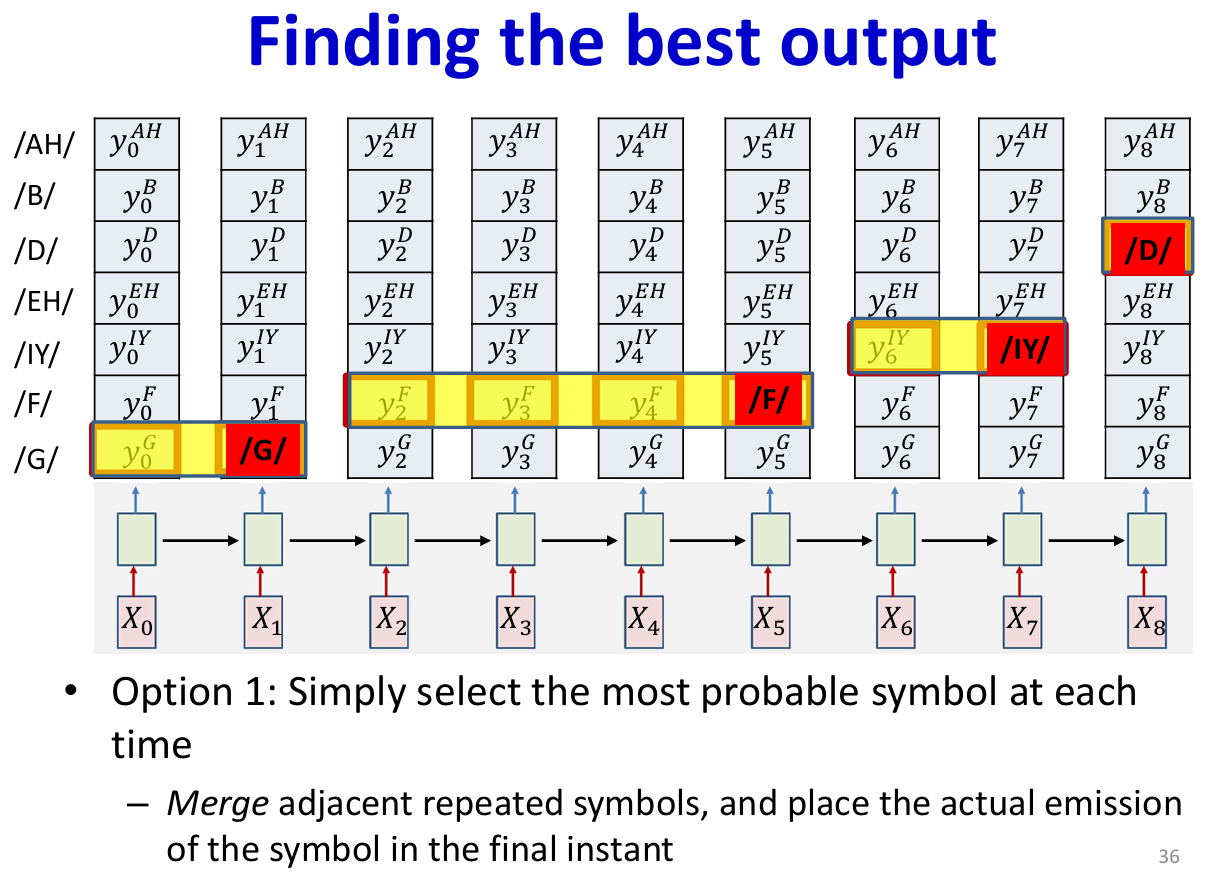

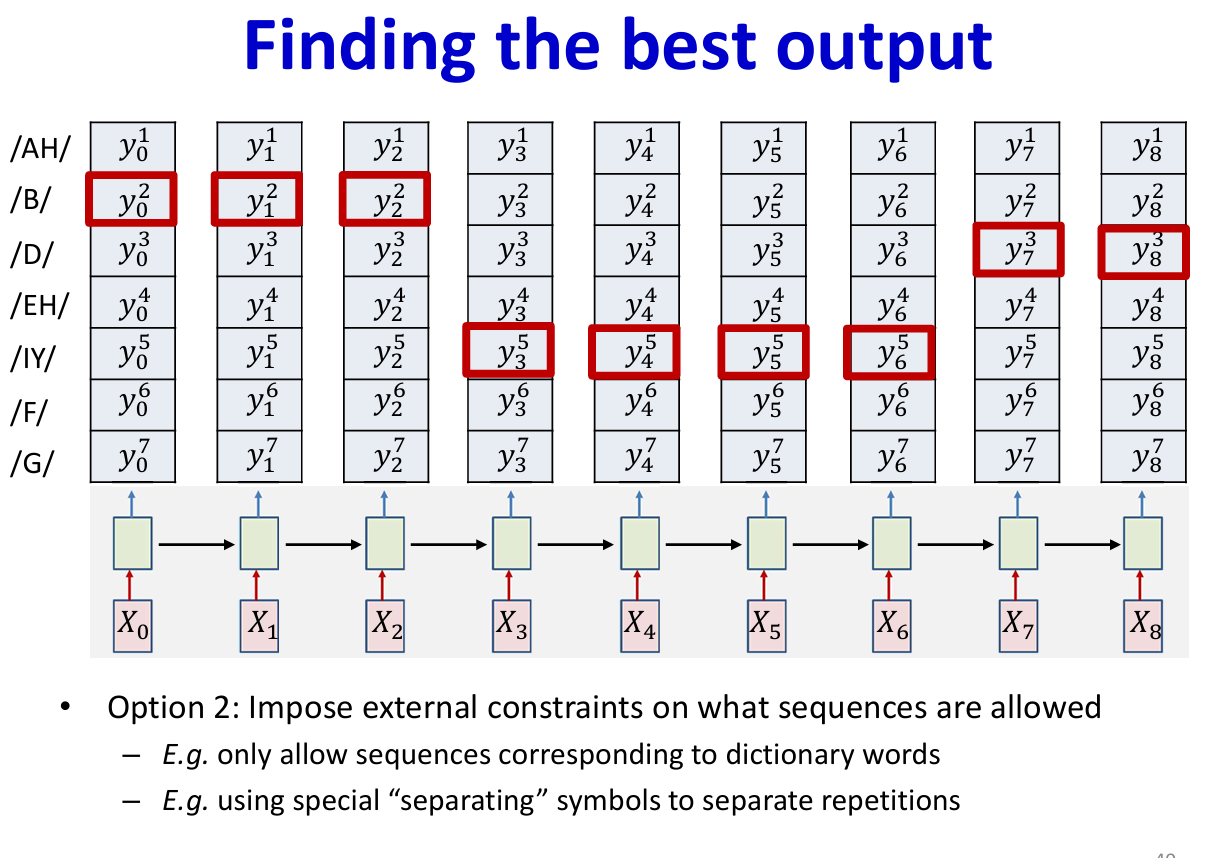

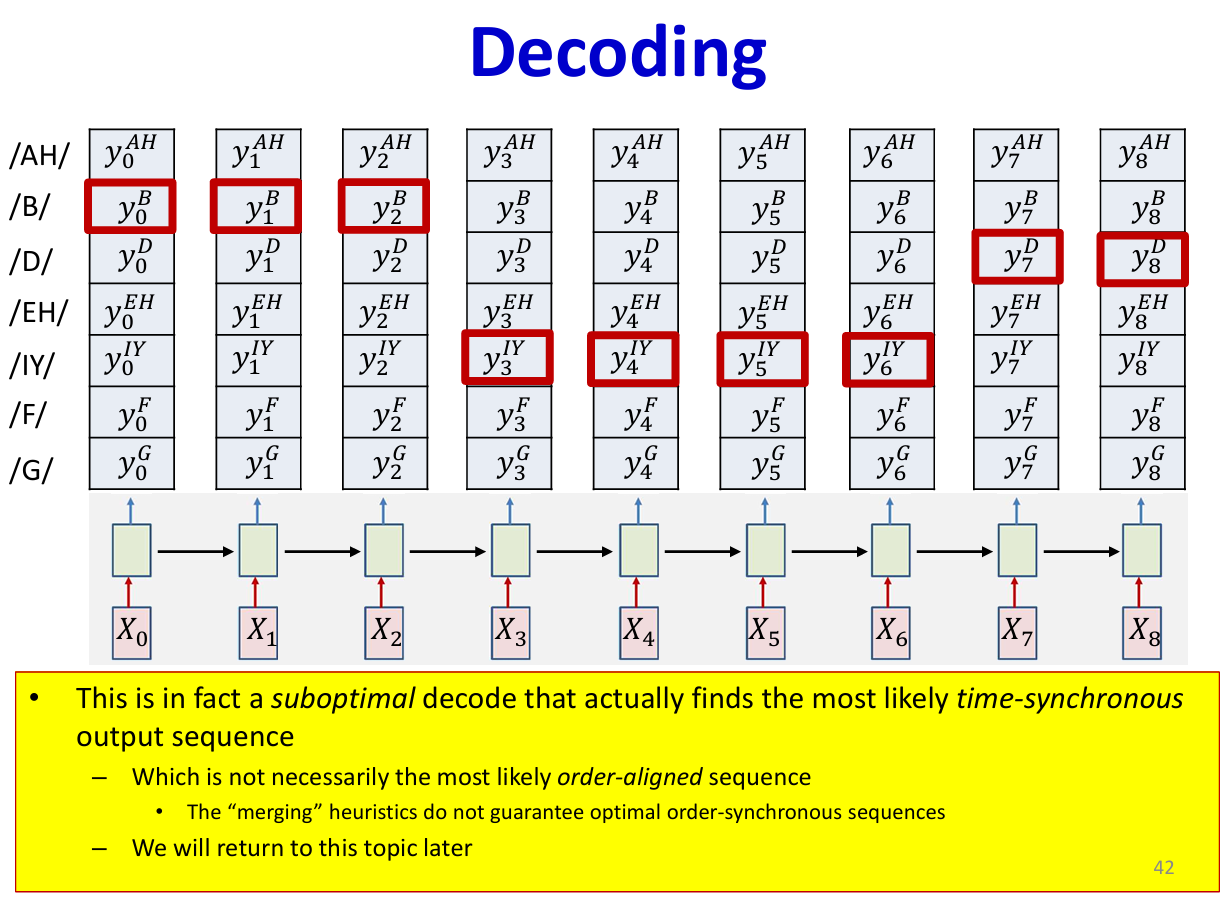

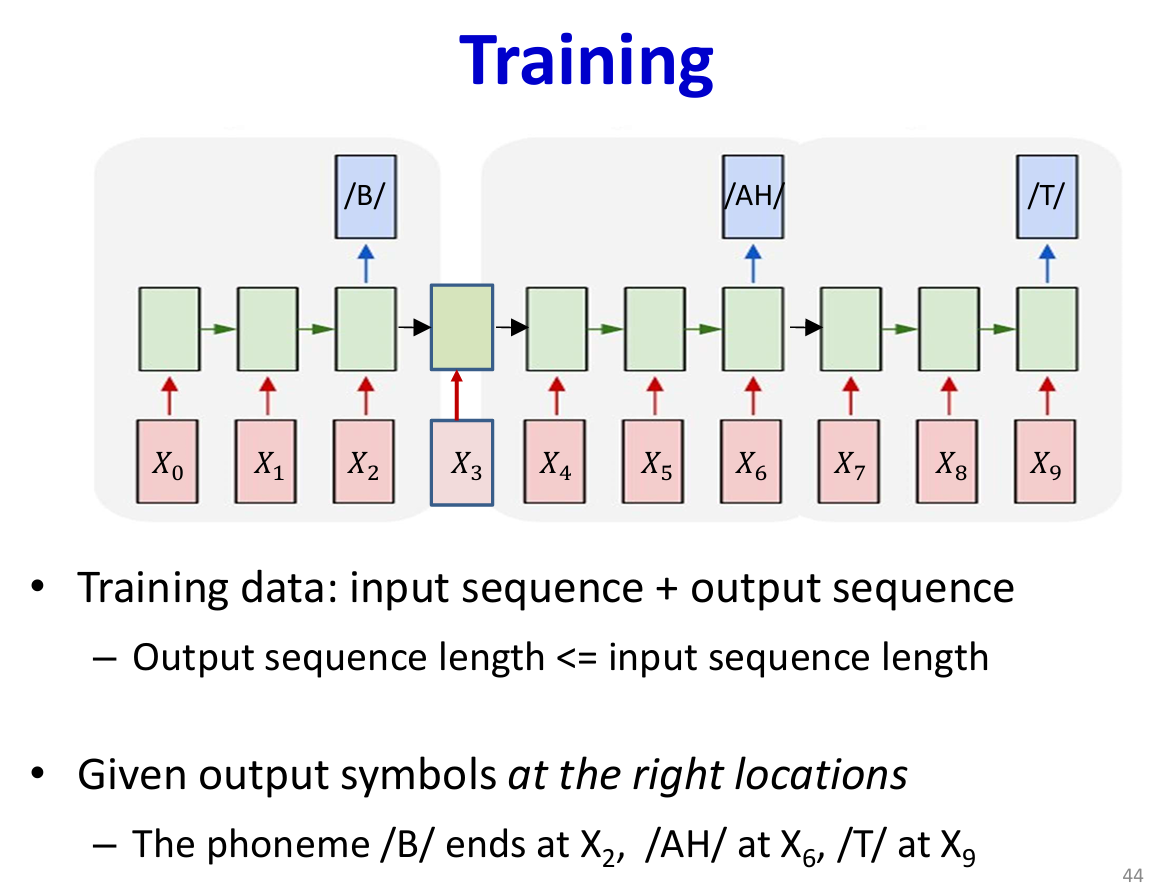

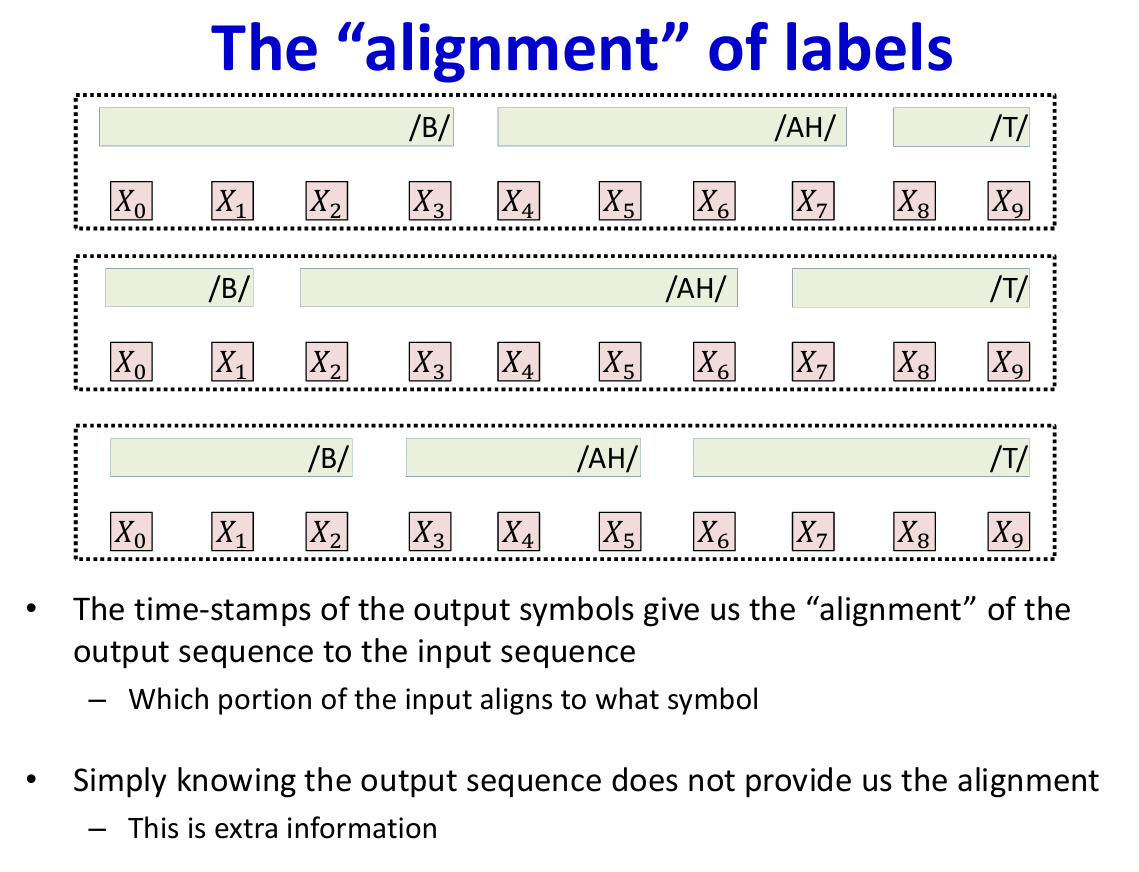

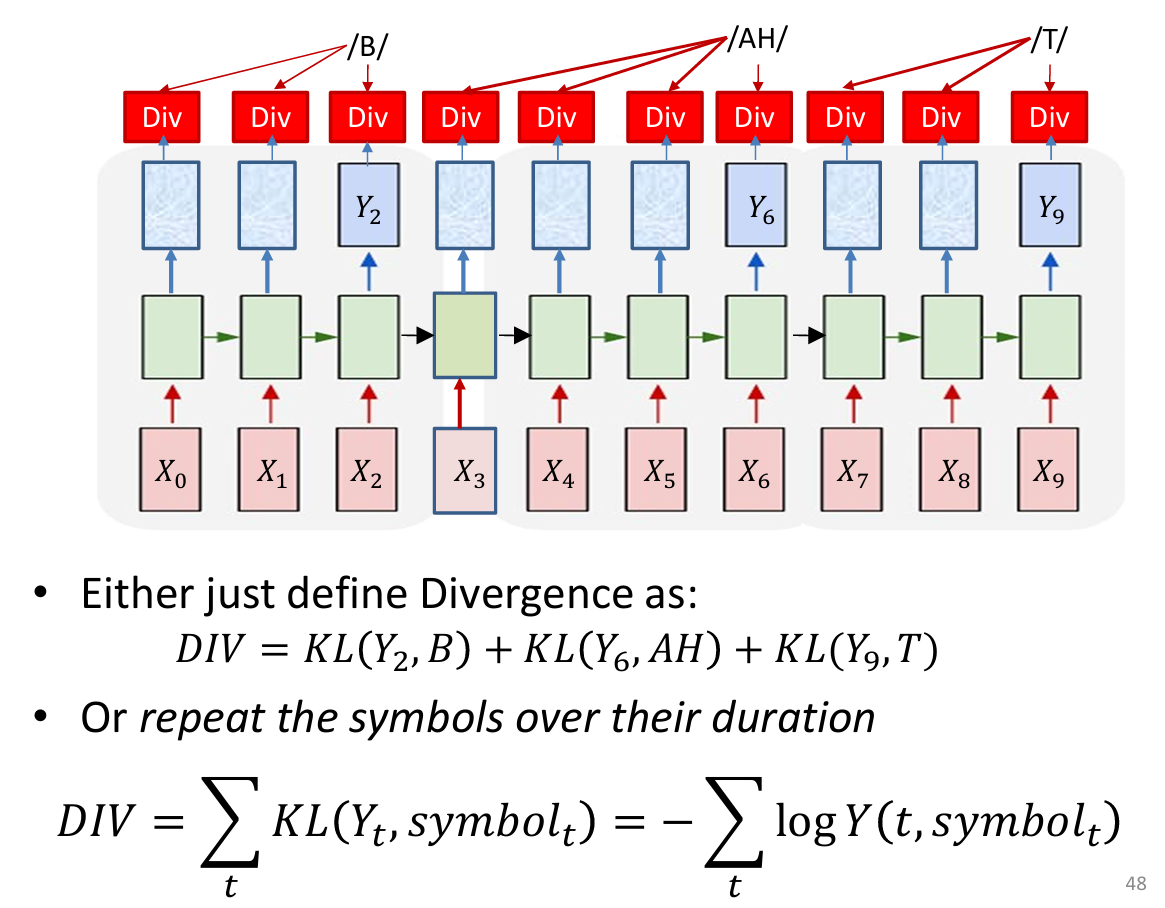

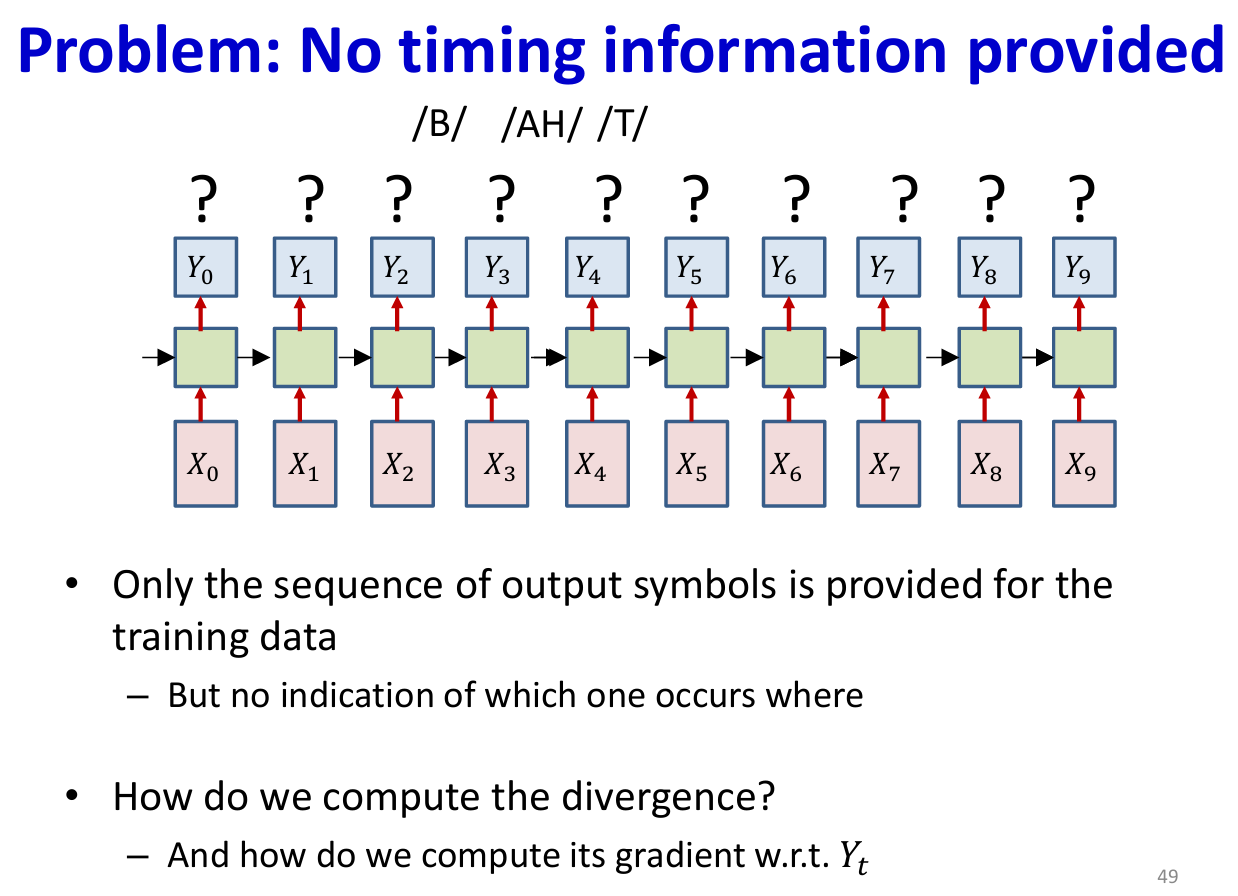

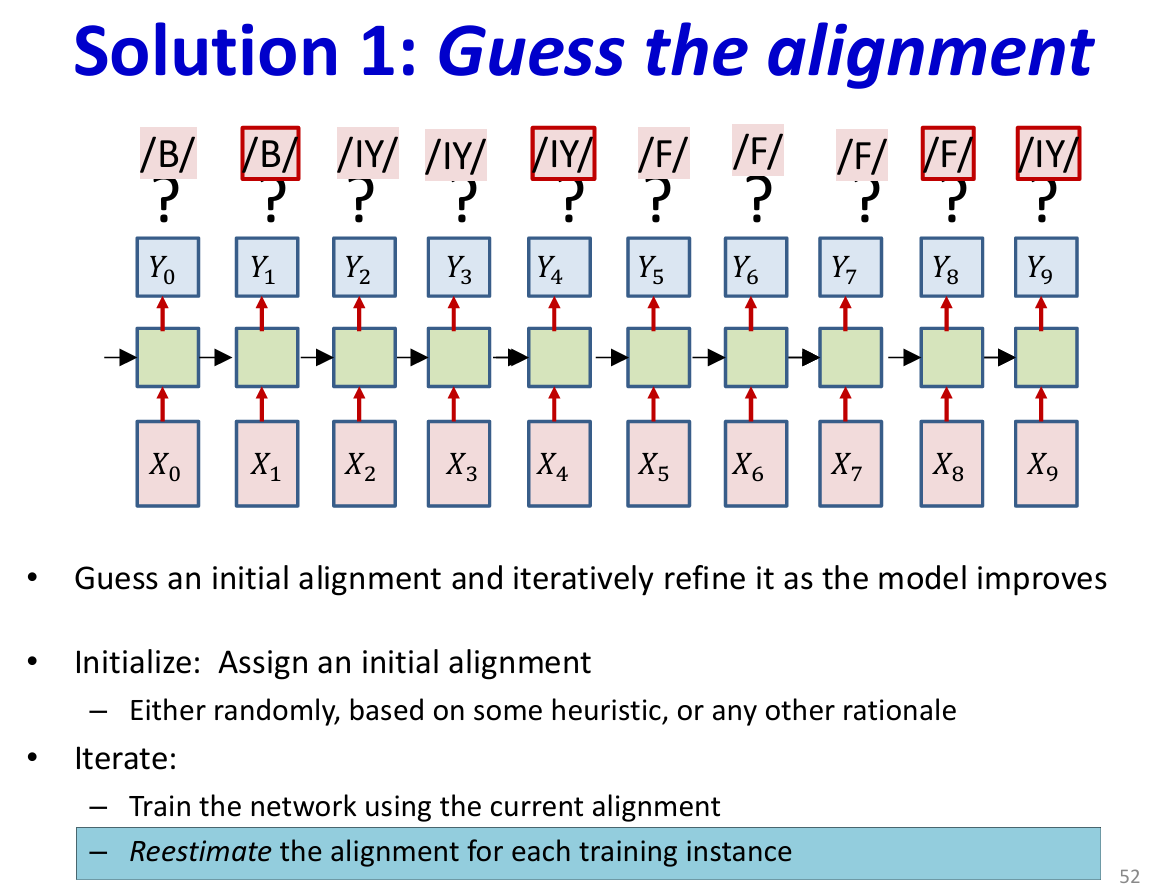

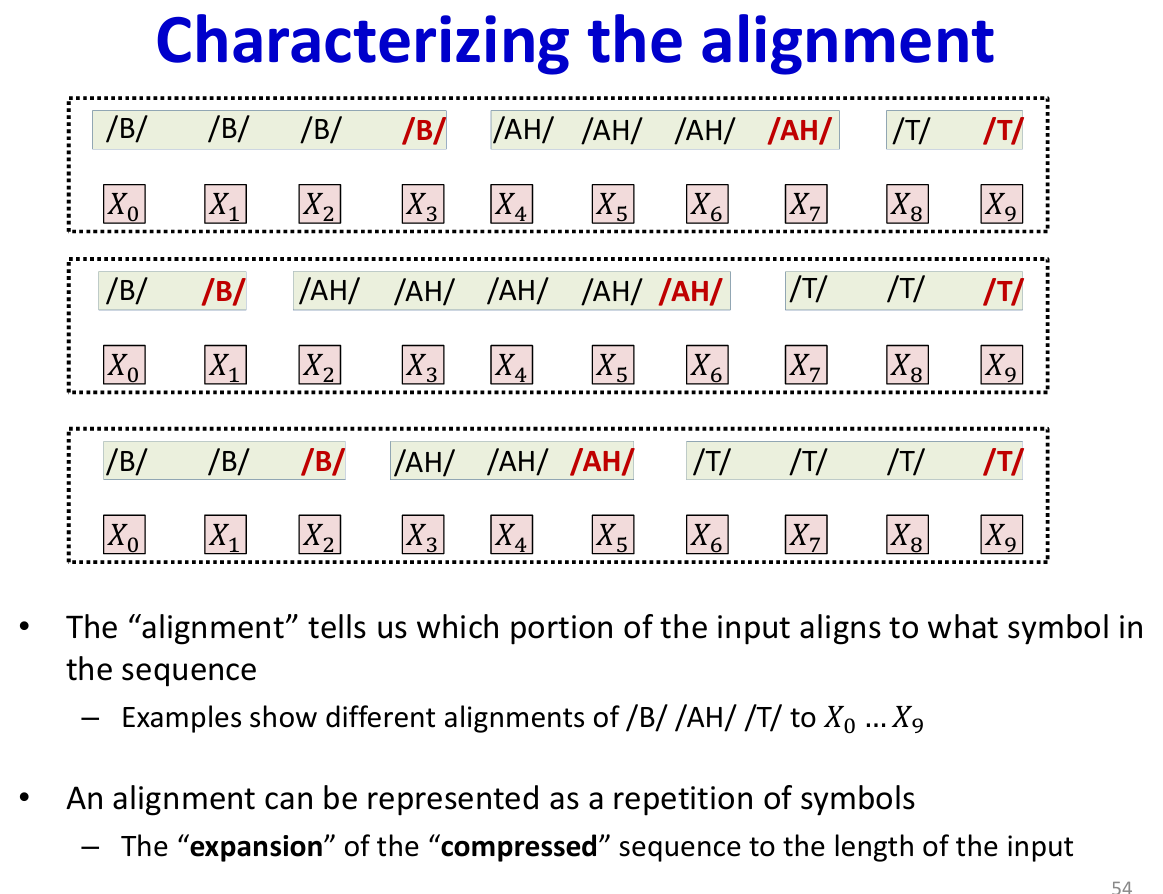

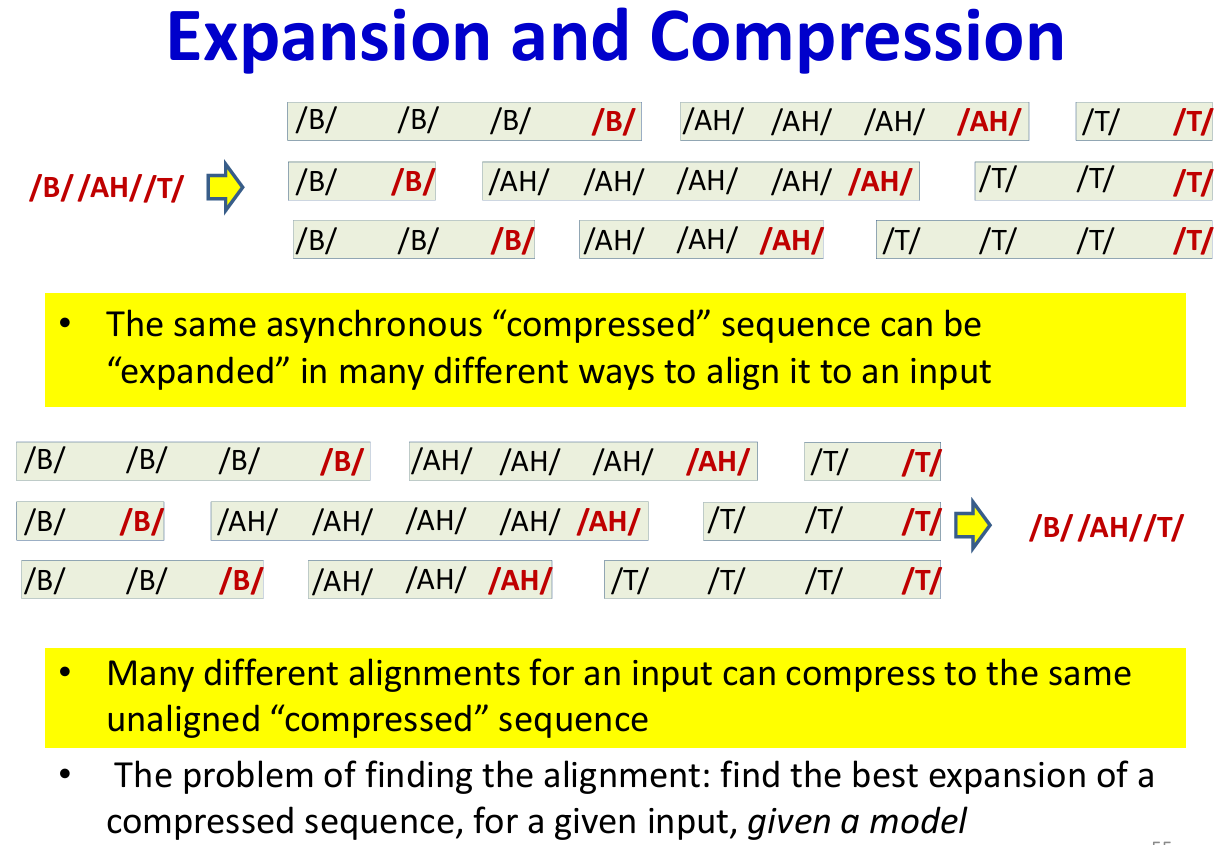

# Chapter 8: The Viterbi Algorithm for Sequence Decoding

---

## 8.1 Motivation: Efficient Path Finding

From Chapter 7, we established that decoding is equivalent to:

> Finding the highest-scoring valid path in an alignment graph.

**Problem**: The number of valid paths grows exponentially with sequence length.

**Solution**: The **Viterbi algorithm** exploits the structure of the problem to find the optimal path in linear time using **dynamic programming**.

---

## 8.2 The Principle of Optimality

The Viterbi algorithm is based on **Bellman's Principle of Optimality**:

> **If the optimal path passes through a state $(i, t)$, then the subpath from the start to $(i, t)$ must itself be optimal.**

This principle allows us to:
1. Decompose the global optimization into local decisions
2. Store partial solutions and reuse them
3. Avoid redundant computation

---

## 8.3 Problem Setup

### Given

1. **Compressed symbol sequence**: $S = (s_0, s_1, \ldots, s_{K-1})$
2. **Network outputs**: $y_t(i) = P(\text{symbol } i \mid X_{0:t})$ for all $t \in \{0, \ldots, N-1\}$, $i \in \mathcal{A}$
3. **Alignment graph**: Grid of size $K \times N$

### Goal

Find the alignment $\tilde{S}^* = (\tilde{s}_0, \ldots, \tilde{s}_{N-1})$ that maximizes:

$$
P(\tilde{S} \mid X) = \prod_{t=0}^{N-1} y_t(\tilde{s}_t)
$$

subject to $\mathcal{C}(\tilde{S}) = S$.

---

## 8.4 Viterbi Variables

### Definition

Let $V(i, t)$ denote the **score of the best path** that:
- Ends at symbol $s_i$ at time $t$
- Follows all alignment constraints up to time $t$

Mathematically:

$$
V(i, t) = \max_{\text{valid paths to } (i, t)} \prod_{\tau=0}^{t} y_\tau(\tilde{s}_\tau)
$$

### Log-Domain (Numerically Stable)

$$
\tilde{V}(i, t) = \log V(i, t) = \max_{\text{valid paths to } (i, t)} \sum_{\tau=0}^{t} \log y_\tau(\tilde{s}_\tau)
$$

---

## 8.5 Viterbi Recurrence

### Allowed Transitions

At each time step, we can:
1. **Stay**: Remain at the same symbol $s_i$
2. **Advance**: Move from symbol $s_{i-1}$ to symbol $s_i$

### Recurrence Relation

$$
V(i, t) = y_t(s_i) \cdot \max\begin{cases}
V(i, t-1) & \text{(stay at } s_i \text{)} \\
V(i-1, t-1) & \text{(advance from } s_{i-1} \text{)}
\end{cases}
$$

In log-domain:

$$
\tilde{V}(i, t) = \log y_t(s_i) + \max\begin{cases}
\tilde{V}(i, t-1) & \text{(stay)} \\
\tilde{V}(i-1, t-1) & \text{(advance)}
\end{cases}
$$

---

## 8.6 Boundary Conditions

### Initial Conditions (Time $t = 0$)

- Must start at the first symbol $s_0$:

$$
V(0, 0) = y_0(s_0)
$$

- Cannot be at any other symbol at time 0:

$$
V(i, 0) = 0 \quad \text{for } i > 0
$$

(Or $\tilde{V}(i, 0) = -\infty$ in log-domain)

### Constraint: Minimum Time per Symbol

Each symbol must occupy at least one time step. If at time $t$ we are at symbol $s_i$, we must have $t \geq i$.

$$
V(i, t) = 0 \quad \text{if } t < i
$$

---

## 8.7 Termination

### Final Score

The optimal alignment score is:

$$
V^* = V(K-1, N-1)
$$

This is the score of the best path ending at the last symbol at the last time step.

### Path Recovery

To recover the actual alignment (not just its score), we maintain **backpointers**:

$$
B(i, t) = \arg\max \begin{cases}
i & \text{if stay is better} \\
i-1 & \text{if advance is better}
\end{cases}
$$

---

## 8.8 Complete Viterbi Algorithm

### Forward Pass (Score Computation)

```
Input: Symbol sequence S = (s₀, ..., s_{K-1}), 
       Network outputs y_t(i) for t ∈ [0, N-1], i ∈ A
Output: Best alignment score V*, backpointers B

# Initialize
V(0, 0) = y_0(s_0)
for i = 1 to K-1:
    V(i, 0) = 0  # Cannot be at later symbols at t=0

# Fill the grid
for t = 1 to N-1:
    for i = 0 to K-1:
        if i == 0:
            # First symbol: can only stay
            V(0, t) = y_t(s_0) * V(0, t-1)
            B(0, t) = 0
        else:
            # Other symbols: stay or advance
            stay_score = V(i, t-1)
            advance_score = V(i-1, t-1)
            
            if stay_score >= advance_score:
                V(i, t) = y_t(s_i) * stay_score
                B(i, t) = i
            else:
                V(i, t) = y_t(s_i) * advance_score
                B(i, t) = i-1

# Termination
V* = V(K-1, N-1)
```

### Backward Pass (Path Recovery)

```
Input: Backpointers B, final position (K-1, N-1)
Output: Optimal alignment (s̃_0, ..., s̃_{N-1})

# Start from the end
i = K-1
alignment = []

for t = N-1 down to 0:
    alignment.prepend(s_i)
    if t > 0:
        i = B(i, t)

return alignment
```

---

## 8.9 Complexity Analysis

| Resource | Complexity |
|----------|------------|
| Time | $O(K \cdot N)$ |
| Space | $O(K \cdot N)$ for full backpointer storage |
| Space (score only) | $O(K)$ if only final score needed |

**Key insight**: Despite exponentially many possible alignments, the algorithm runs in **polynomial time** due to:
1. Optimal substructure
2. Overlapping subproblems
3. Efficient memoization

---

## 8.10 Worked Example

### Setup

- Symbol sequence: $S = (A, B)$, so $K = 2$
- Input length: $N = 4$
- Network outputs (probabilities):

| Time $t$ | $y_t(A)$ | $y_t(B)$ |
|----------|----------|----------|
| 0 | 0.9 | 0.1 |
| 1 | 0.6 | 0.4 |
| 2 | 0.3 | 0.7 |
| 3 | 0.2 | 0.8 |

### Forward Pass

**$t = 0$:**
- $V(A, 0) = 0.9$
- $V(B, 0) = 0$ (must start at A)

**$t = 1$:**
- $V(A, 1) = 0.6 \times V(A, 0) = 0.6 \times 0.9 = 0.54$
- $V(B, 1) = 0.4 \times \max(V(B, 0), V(A, 0)) = 0.4 \times 0.9 = 0.36$

**$t = 2$:**
- $V(A, 2) = 0.3 \times V(A, 1) = 0.3 \times 0.54 = 0.162$
- $V(B, 2) = 0.7 \times \max(V(B, 1), V(A, 1)) = 0.7 \times 0.54 = 0.378$

**$t = 3$:**
- $V(A, 3) = 0.2 \times V(A, 2) = 0.2 \times 0.162 = 0.0324$
- $V(B, 3) = 0.8 \times \max(V(B, 2), V(A, 2)) = 0.8 \times 0.378 = 0.3024$

### Result

- **Best score**: $V^* = V(B, 3) = 0.3024$
- **Best alignment**: Tracing backpointers gives $(A, A, B, B)$

---

## 8.11 Viterbi Training (Hard Alignment Training)

The Viterbi algorithm can be used for **training** as well as inference:

### Algorithm

1. **Forward pass**: Compute network outputs $y_t(i)$
2. **Viterbi decode**: Find best alignment $\tilde{S}^* = \text{Viterbi}(Y, S)$
3. **Define loss**: Treat alignment as ground truth:
   $$
   \mathcal{L} = -\sum_{t=0}^{N-1} \log y_t(\tilde{s}_t^*)
   $$
4. **Backpropagate**: Standard BPTT
5. **Update parameters**
6. **Repeat**: New parameters $\rightarrow$ new alignment $\rightarrow$ iterate

### Properties

| Aspect | Description |
|--------|-------------|
| Type | Hard EM-like algorithm |
| Alignment | Single best (no uncertainty) |
| Gradient | Sparse (only at aligned positions) |
| Stability | Can be unstable early in training |

---

## 8.12 Limitations of Viterbi Training

### Problem 1: Early Commitment

- Wrong alignment early $\rightarrow$ reinforced by training
- Model may never escape local optima

### Problem 2: No Uncertainty

- Ignores all alignments except the best
- Does not account for alignment ambiguity

### Problem 3: Hard Gradients

- Gradient is zero for non-aligned symbols
- No signal to adjust probabilities of alternative alignments

> **These limitations motivate CTC**, which considers **all valid alignments** simultaneously.

---

## 8.13 Viterbi vs. CTC: Preview

| Aspect | Viterbi Training | CTC |
|--------|-----------------|-----|
| Alignments considered | Best only | All valid |
| Objective | $\max$ over alignments | $\sum$ over alignments |
| Gradient | Hard | Soft (expected alignment) |
| Theoretical foundation | Approximate | Exact likelihood |

---

## 8.14 Summary

> **The Viterbi algorithm finds the most probable alignment between a symbol sequence and time-indexed network outputs in $O(K \cdot N)$ time using dynamic programming. It exploits the principle of optimality to avoid exponential enumeration, enabling practical decoding and (approximate) training for sequence-to-sequence problems with unknown alignment.**

---

## Key Equations Summary

| Equation | Description |
|----------|-------------|
| $V(i, t) = y_t(s_i) \cdot \max(V(i, t-1), V(i-1, t-1))$ | Viterbi recurrence |
| $V(0, 0) = y_0(s_0)$ | Initial condition |
| $V^* = V(K-1, N-1)$ | Optimal score |
| $\mathcal{L}_{\text{Viterbi}} = -\sum_t \log y_t(\tilde{s}_t^*)$ | Training loss |

---

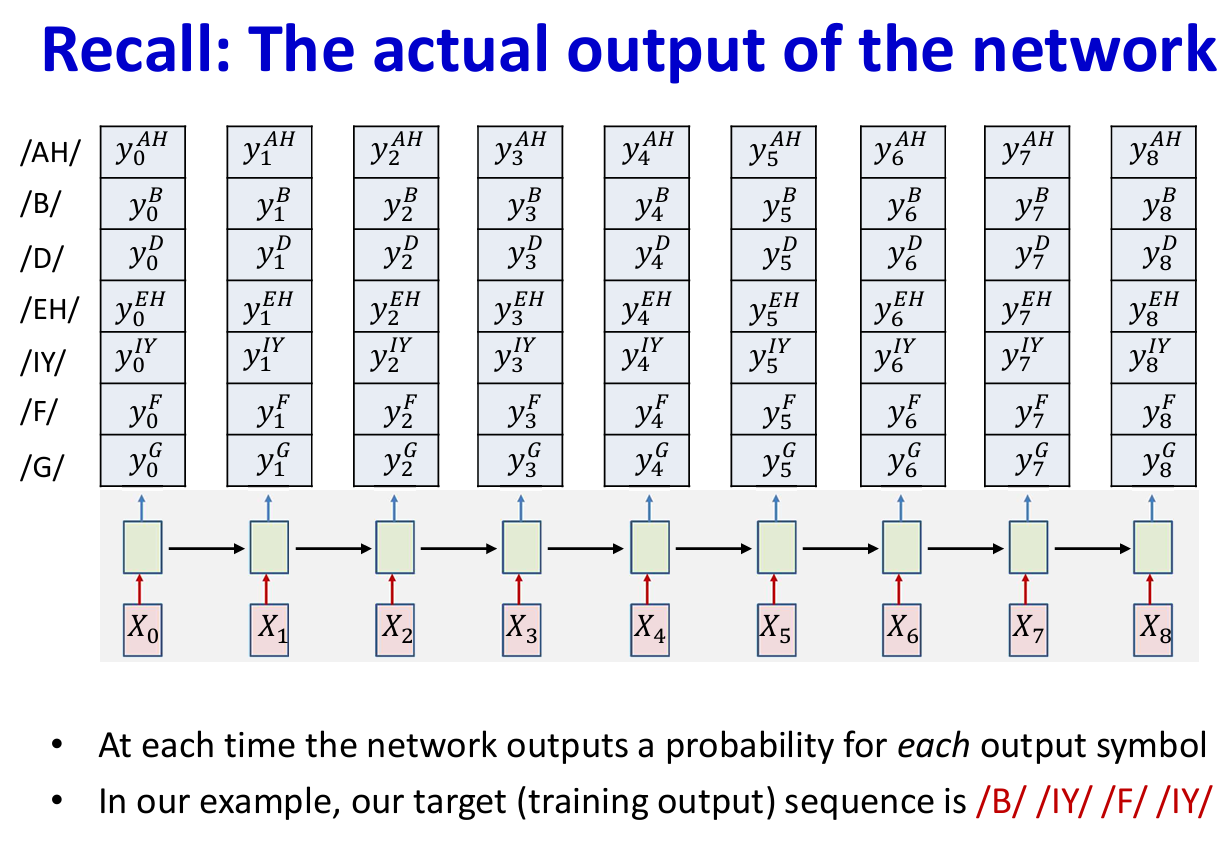

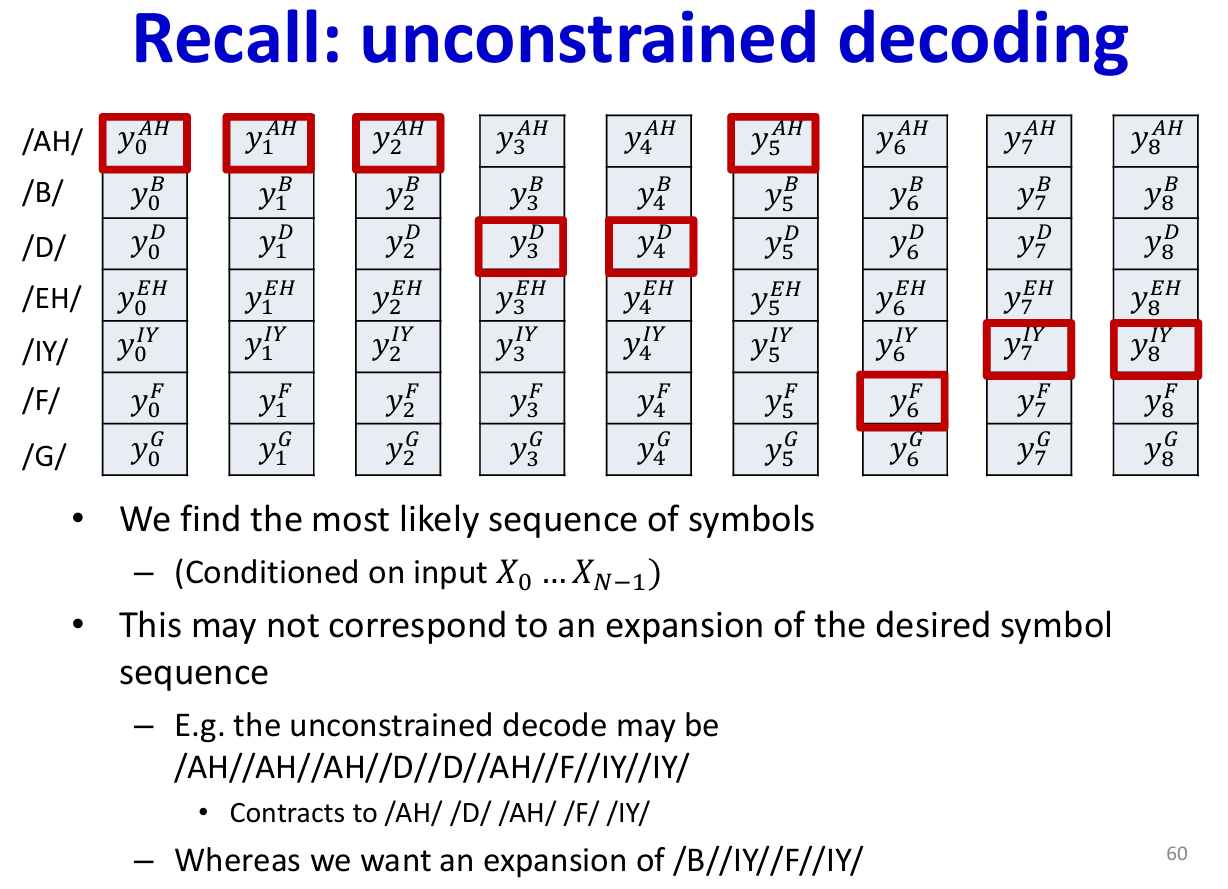

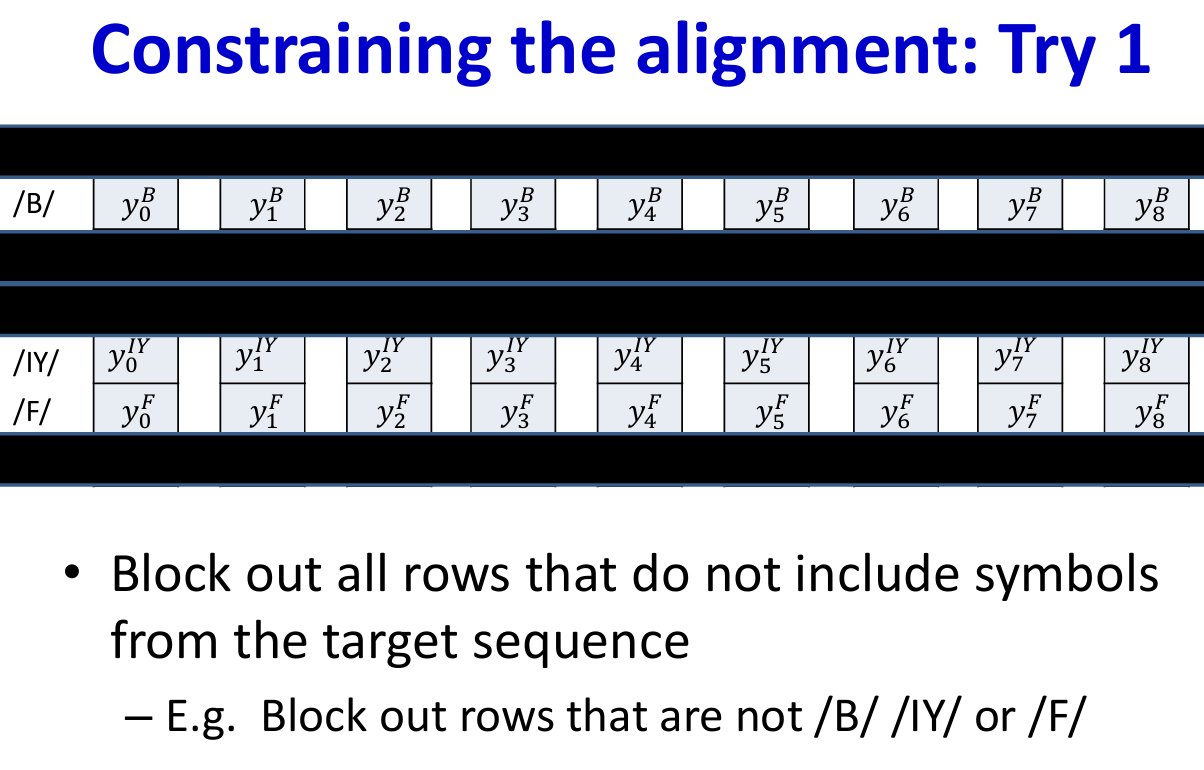

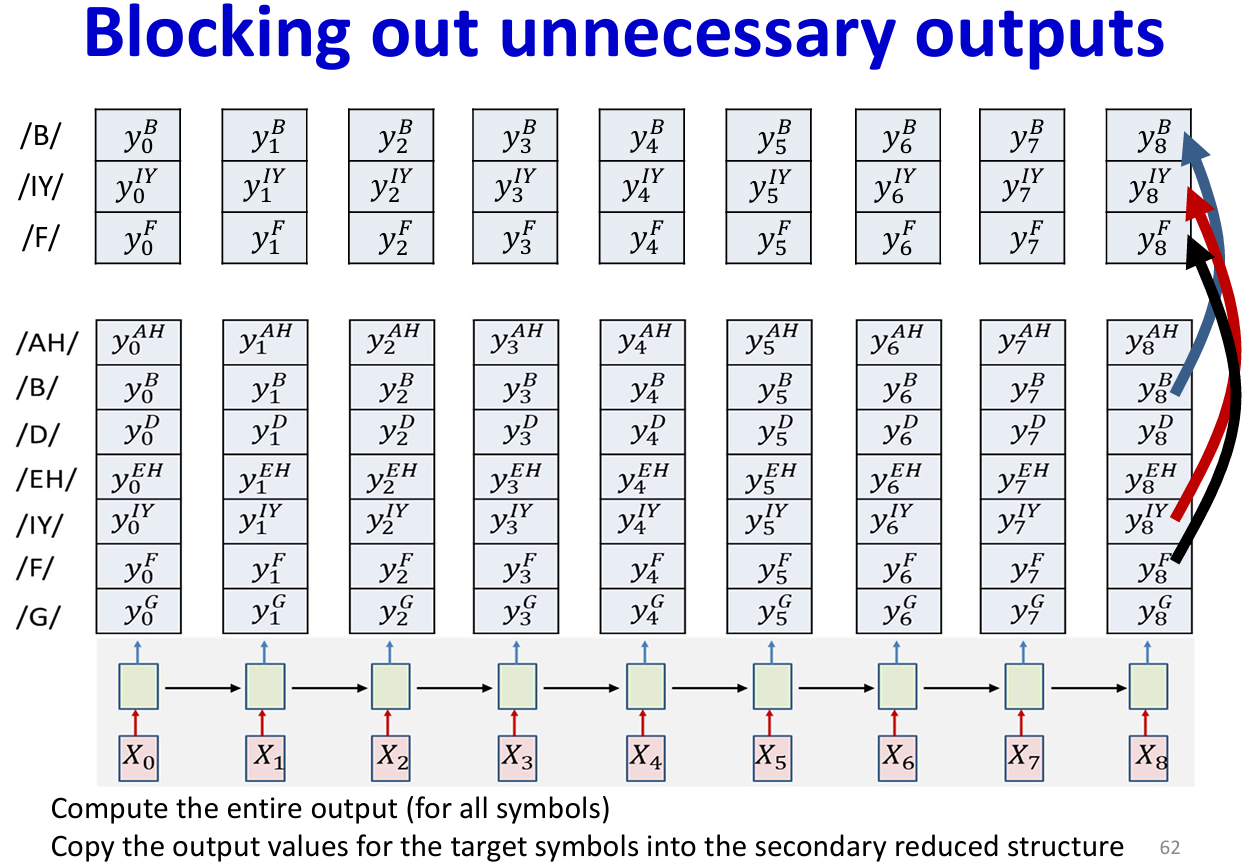

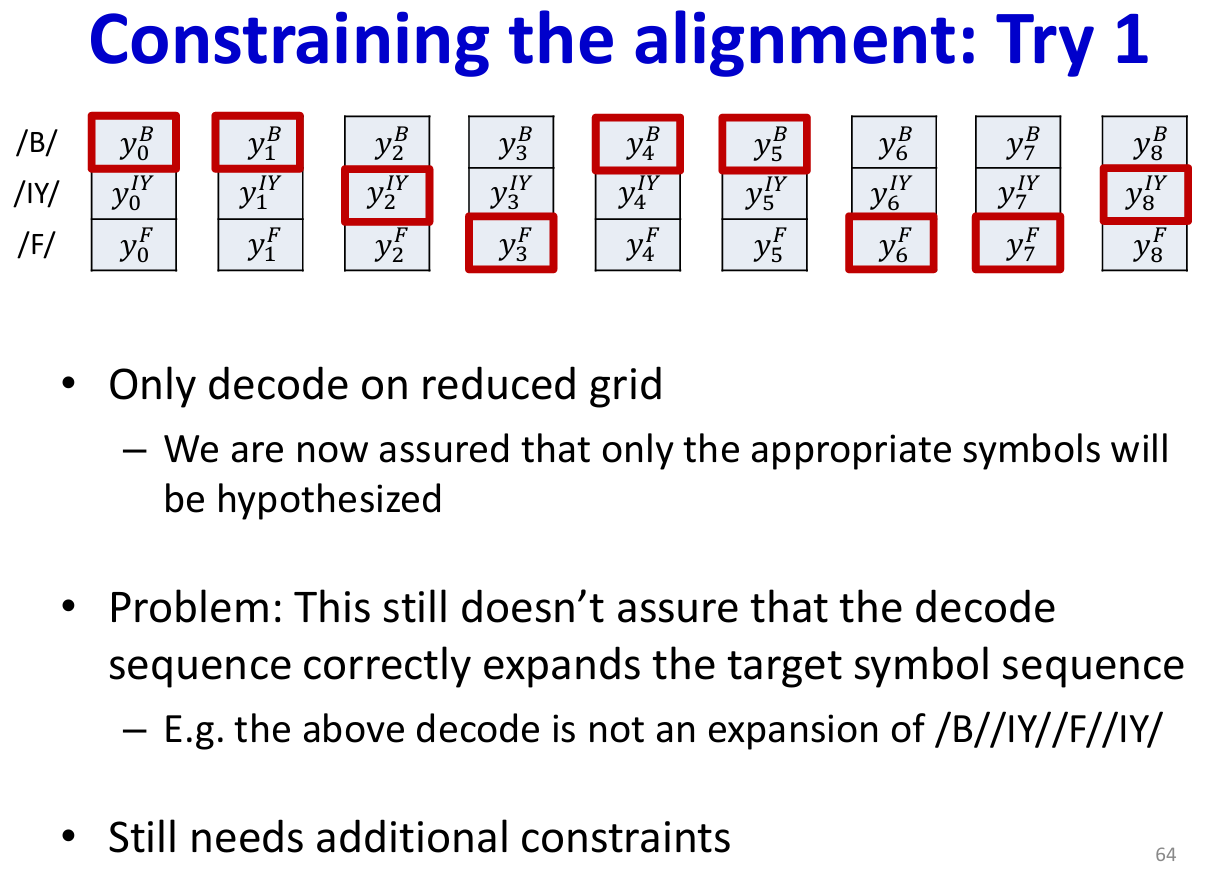

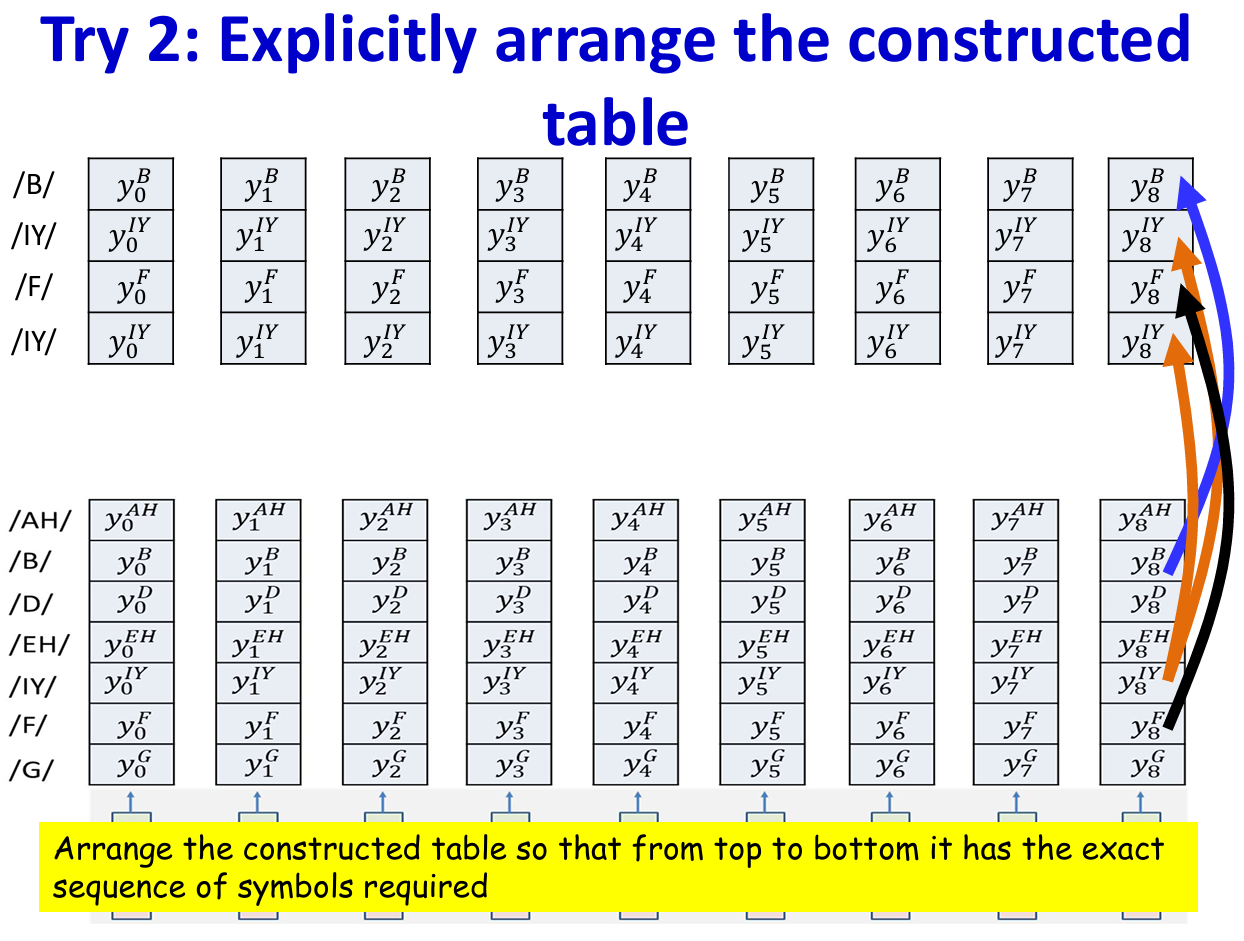

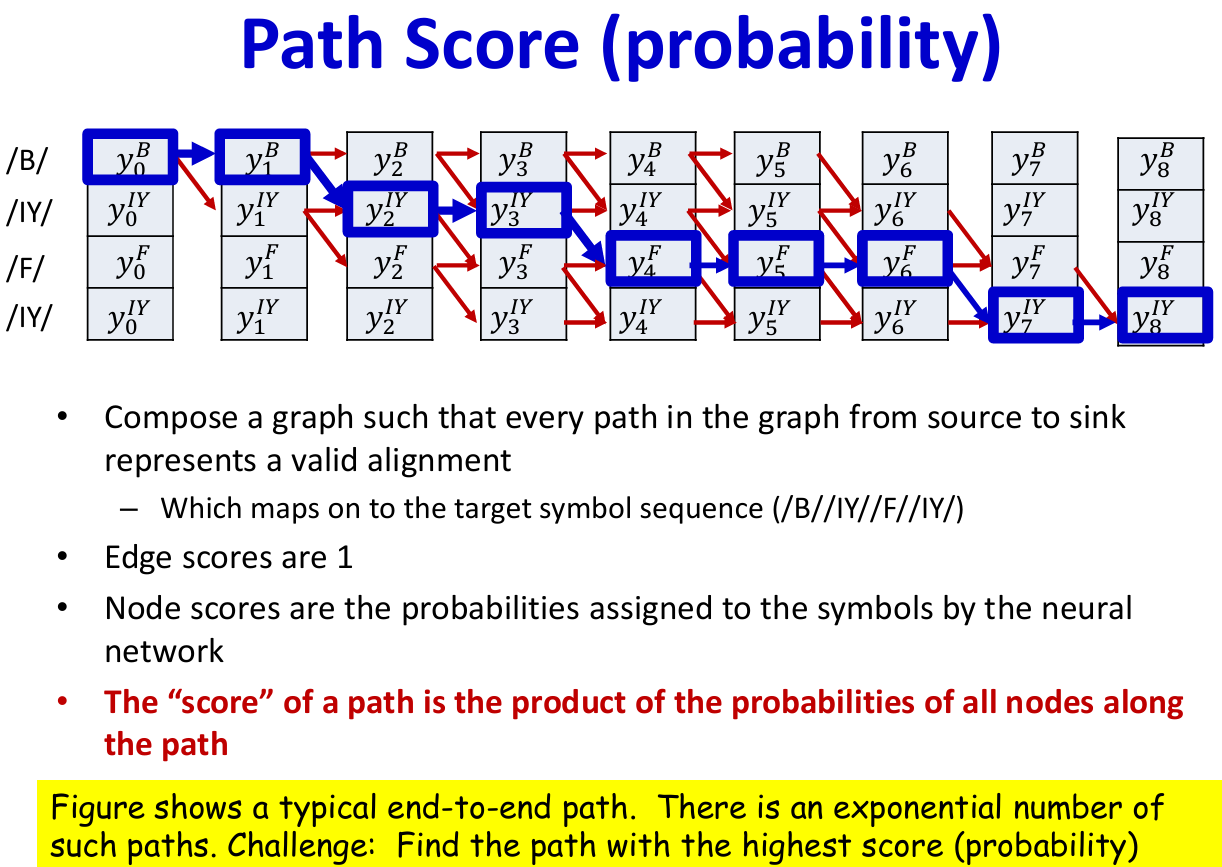

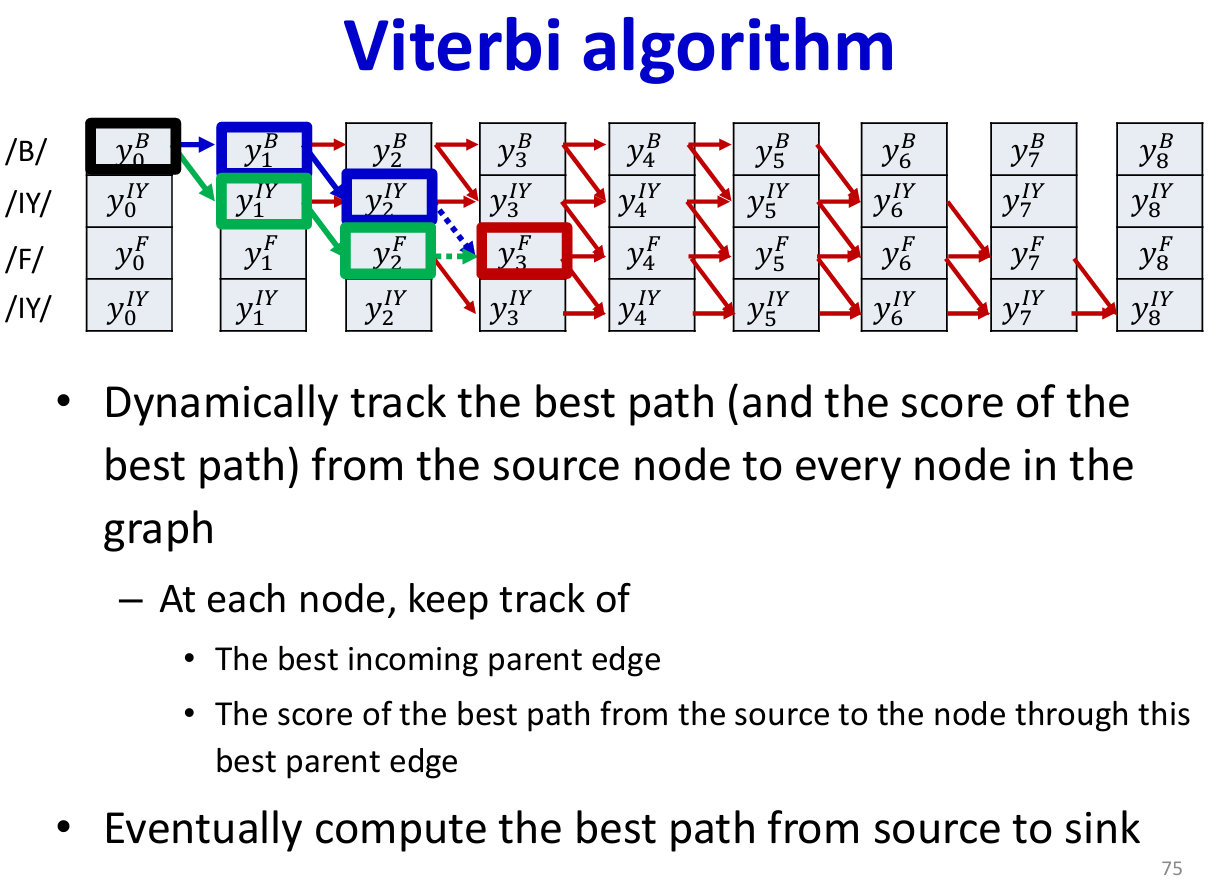

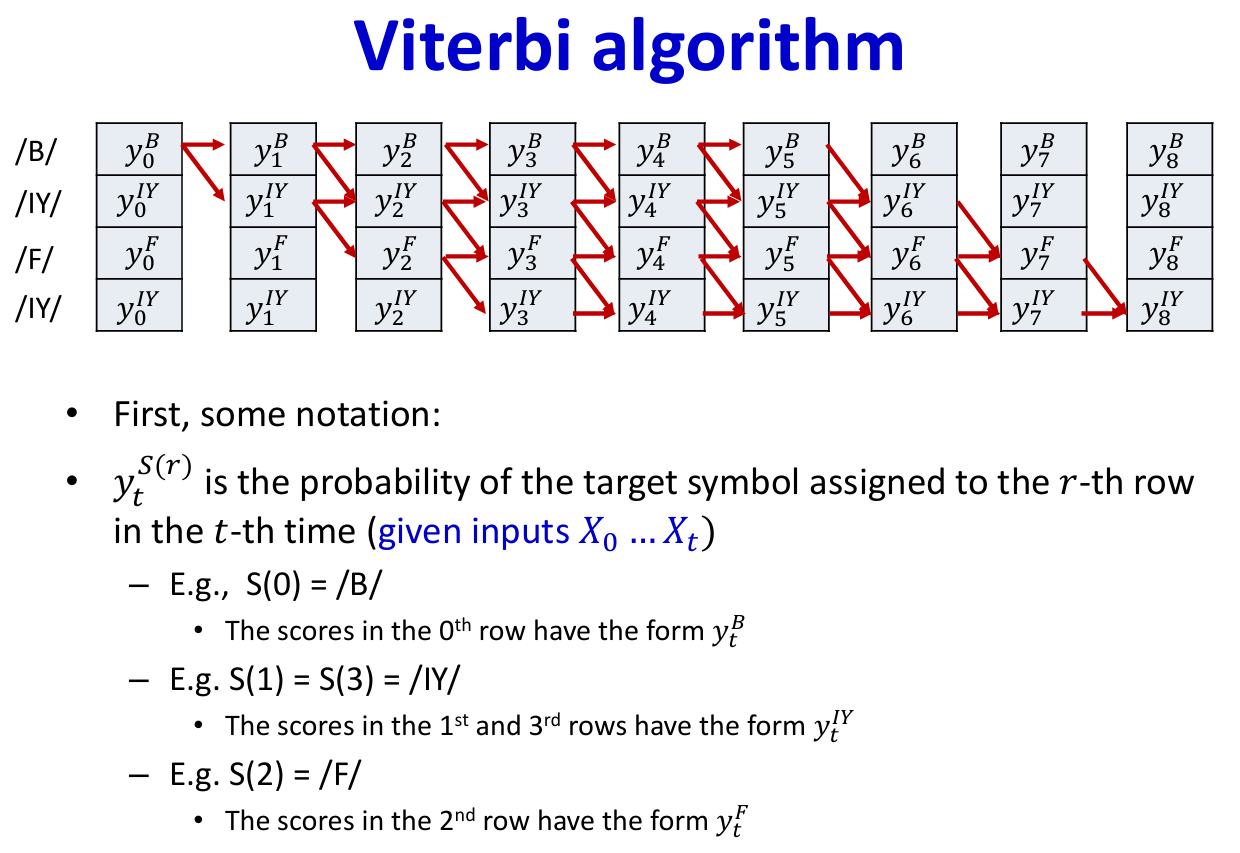

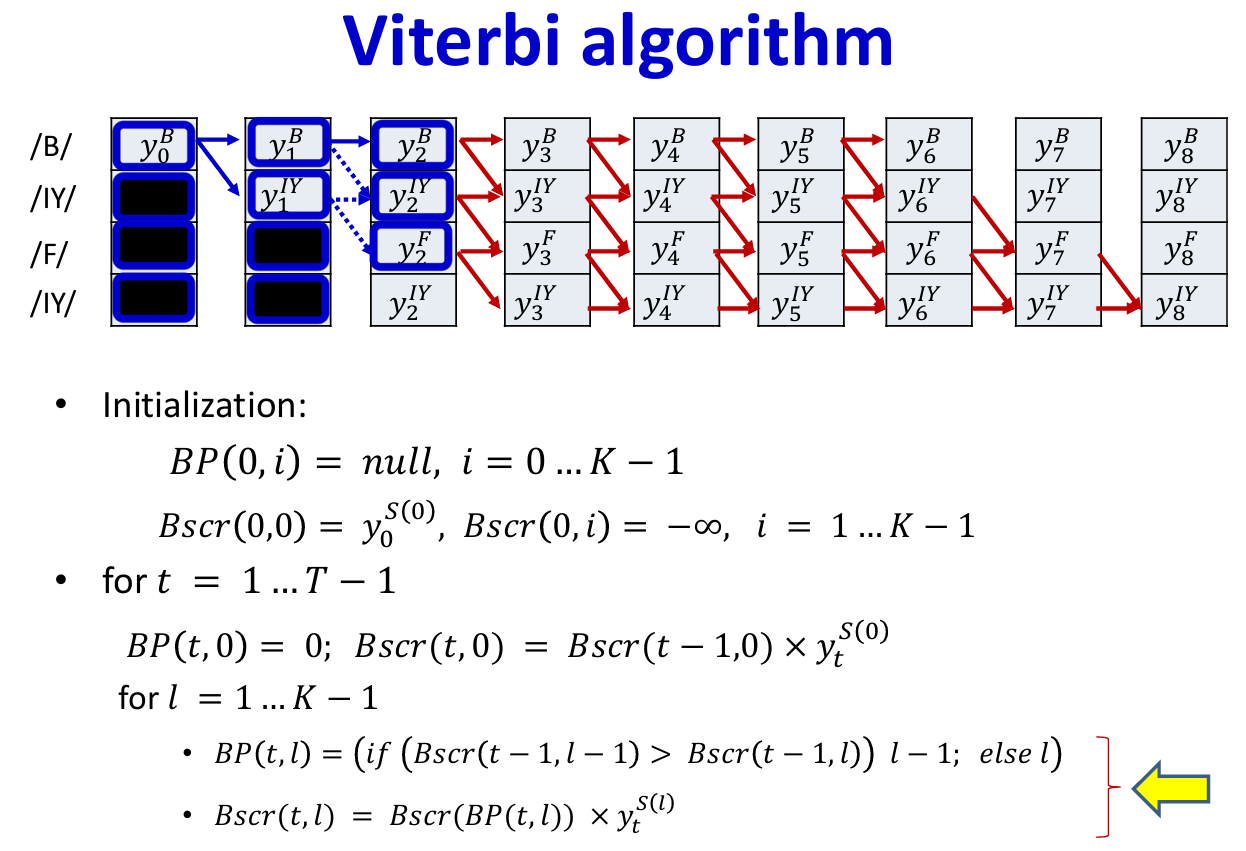

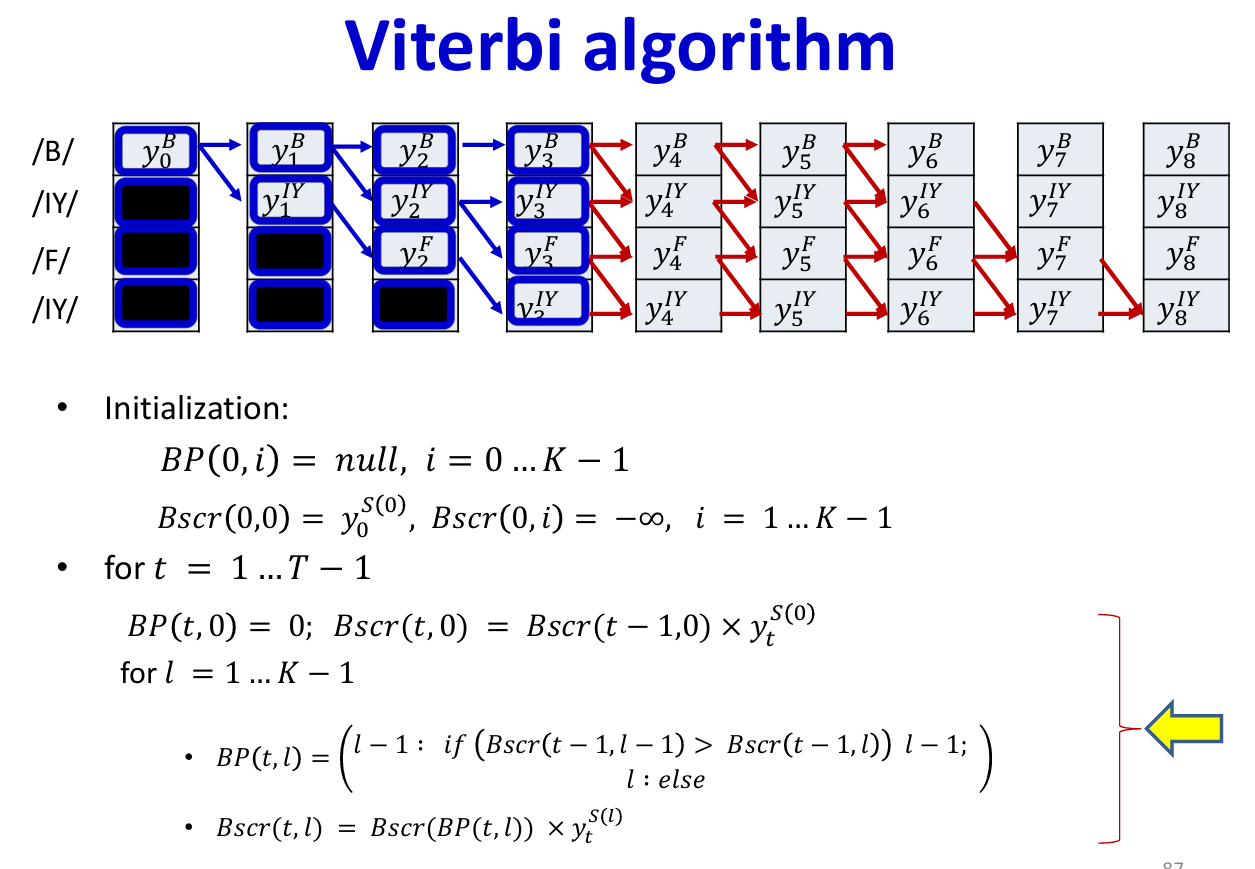

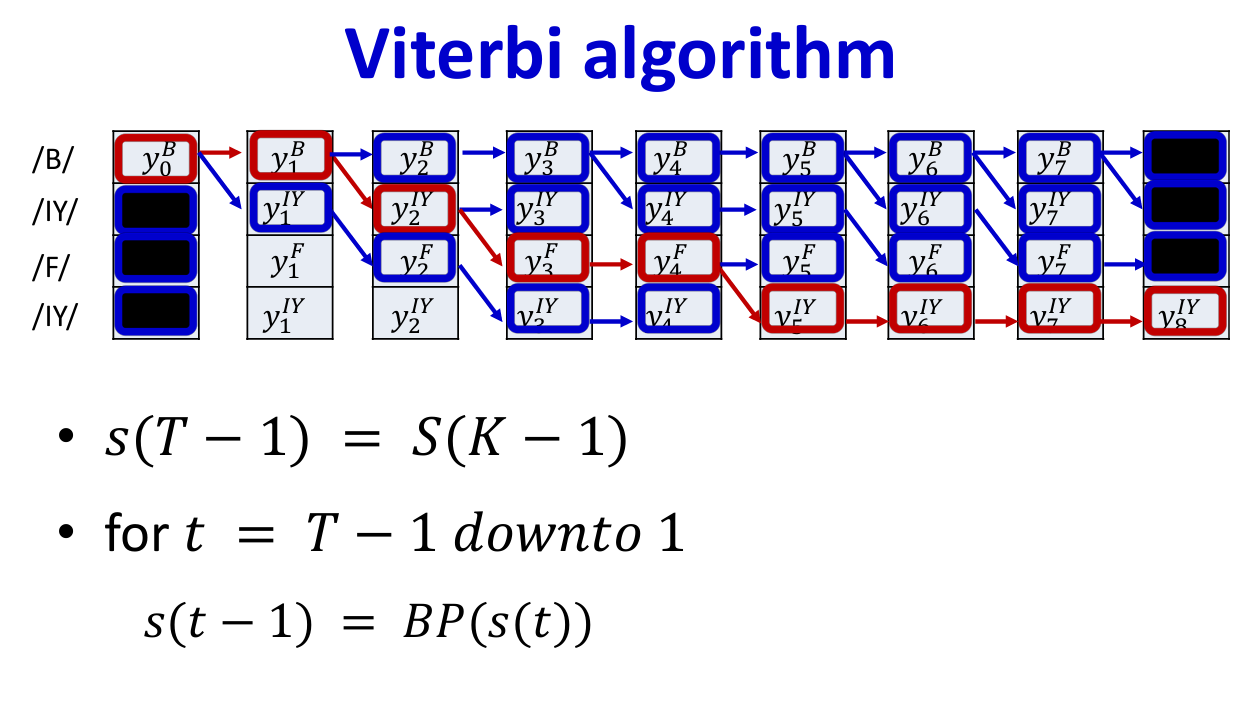

# Chapter 9: Connectionist Temporal Classification (CTC) — From First Principles

---

## 9.1 The Fundamental Problem CTC Solves

### 9.1.1 Why Viterbi Training Is Not Enough

In Chapter 8, we explored Viterbi training, which finds the **single best alignment** between input and output:

$$
\pi^* = \underset{\pi \in \mathcal{A}(S)}{\arg\max} \prod_{t=1}^{T} y_t(\pi_t)
$$

**The problem**: Viterbi training commits to one alignment and ignores all others. This is suboptimal because:

1. **Information loss**: Many valid alignments exist; using only one discards useful information
2. **Gradient sparsity**: Only the symbols along the best path receive gradient updates
3. **Mode collapse**: The model may converge to a local minimum based on an initially poor alignment

### 9.1.2 The CTC Philosophy

**Connectionist Temporal Classification (CTC)** takes a fundamentally different approach:

> **Core Idea**: Instead of finding the best alignment, **sum over ALL valid alignments**.

$$
P(S \mid X) = \sum_{\pi \in \mathcal{A}(S)} P(\pi \mid X) = \sum_{\pi \in \mathcal{A}(S)} \prod_{t=1}^{T} y_t(\pi_t)
$$

This is the **marginalization** principle from probability theory: if you don't know which alignment is correct, sum over all possibilities weighted by their probabilities.

---

## 9.2 The Blank Symbol: A Critical Innovation

### 9.2.1 The Need for Blank

Consider transcribing the word "HELLO" from audio. The input has $T = 100$ frames, but the output has only 5 characters. Without any mechanism to handle:
- **Silence/noise frames** that don't correspond to any character
- **Repeated characters** like the double 'L' in "HELLO"

We cannot properly represent the alignment.

### 9.2.2 Introducing the Blank Token

CTC introduces a special **blank symbol** $\epsilon$ (sometimes written as $\langle b \rangle$ or `-`):

**Extended Alphabet**:
$$
\Sigma' = \Sigma \cup \{\epsilon\}
$$

where $\Sigma$ is the original symbol set.

**Example**: For speech recognition with 26 letters:
- Original: $\Sigma = \{a, b, c, \ldots, z\}$ — 26 symbols
- Extended: $\Sigma' = \{a, b, c, \ldots, z, \epsilon\}$ — 27 symbols

### 9.2.3 The Role of Blank

The blank symbol serves two critical purposes:

1. **Absorbing non-informative frames**: Frames that don't clearly belong to any symbol can be assigned to $\epsilon$

2. **Separating repeated symbols**: To distinguish "HELLO" (with 2 L's) from "HELO" (with 1 L), we need blanks between repeated characters

---

## 9.3 The CTC Collapse Function

### 9.3.1 From Alignment to Output: The $\mathcal{B}$ Operator

Given a frame-level alignment $\pi = (\pi_1, \pi_2, \ldots, \pi_T)$, we define the **collapse function** $\mathcal{B}$:

$$
\mathcal{B}(\pi) = \text{collapse}(\text{remove\_blanks}(\pi))
$$

**Step 1**: Remove all blank symbols $\epsilon$

**Step 2**: Collapse consecutive repeated symbols into one

### 9.3.2 Worked Examples

**Example 1**: Simple collapse
$$
\pi = (\epsilon, c, c, \epsilon, a, a, a, t, \epsilon)
$$
- After removing blanks: $(c, c, a, a, a, t)$
- After collapsing repeats: $(c, a, t)$
- Therefore: $\mathcal{B}(\pi) = \text{"cat"}$

**Example 2**: Repeated characters in output
$$
\pi = (h, h, \epsilon, e, l, l, \epsilon, l, o)
$$
- After removing blanks: $(h, h, e, l, l, l, o)$
- After collapsing repeats: $(h, e, l, l, o)$ ← **Wait!** This is wrong!

**Critical insight**: We collapse **consecutive** repeats, so $(h, h)$ becomes $(h)$, and $(l, l, l)$ becomes $(l)$, giving us "helo" — NOT "hello"!

**To produce "hello"**, we need a blank between the two L's:
$$
\pi = (h, \epsilon, e, \epsilon, l, \epsilon, l, o)
$$
- After removing blanks: $(h, e, l, l, o)$
- After collapsing repeats: $(h, e, l, l, o)$ ✓

### 9.3.3 The Inverse Mapping: All Valid Alignments

Given output $S$, the set of all valid alignments is:

$$
\mathcal{A}(S) = \{\pi \in (\Sigma')^T : \mathcal{B}(\pi) = S\}
$$

**Key property**: $|\mathcal{A}(S)|$ can be **exponentially large** in $T$.

---

## 9.4 The CTC Objective Function

### 9.4.1 Formal Definition

The CTC probability of output sequence $S$ given input $X$ is:

$$
\boxed{P_{\text{CTC}}(S \mid X) = \sum_{\pi : \mathcal{B}(\pi) = S} \prod_{t=1}^{T} y_t(\pi_t)}
$$

where $y_t(k)$ is the network's output probability for symbol $k$ at time $t$.

### 9.4.2 Training Objective

For a training pair $(X, S)$, we maximize the log-likelihood:

$$
\mathcal{L} = \log P_{\text{CTC}}(S \mid X)
$$

Or equivalently, minimize the **CTC loss**:

$$
\mathcal{L}_{\text{CTC}} = -\log P_{\text{CTC}}(S \mid X)
$$

### 9.4.3 The Computational Challenge

**Problem**: The sum over all alignments has exponentially many terms.

For an output of length $L$ and input of length $T$:
- Number of alignments $\approx \binom{T+L}{L}$ (very rough lower bound)
- For $T = 100$, $L = 10$: this is $\approx 10^{13}$ alignments!

**Solution**: Dynamic programming via the **Forward-Backward Algorithm**.

---

## 9.5 The CTC Extended Sequence

### 9.5.1 Construction

To facilitate the dynamic programming, we construct an **extended sequence** $S'$ by inserting blanks:

Given $S = (s_1, s_2, \ldots, s_L)$, define:

$$
S' = (\epsilon, s_1, \epsilon, s_2, \epsilon, \ldots, \epsilon, s_L, \epsilon)
$$

**Length**: $|S'| = 2L + 1$

**Example**: For $S = \text{"cat"}$:
$$
S' = (\epsilon, c, \epsilon, a, \epsilon, t, \epsilon)
$$

### 9.5.2 Indexing Convention

We index $S'$ from $1$ to $2L + 1$:

| Index $i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|-----------|---|---|---|---|---|---|---|
| Symbol $s'_i$ | $\epsilon$ | c | $\epsilon$ | a | $\epsilon$ | t | $\epsilon$ |

**Odd indices**: Always blanks $\epsilon$
**Even indices**: Always characters from $S$

---

## 9.6 The Forward Algorithm for CTC

### 9.6.1 The Forward Variable

Define the **forward variable**:

$$
\alpha_t(i) = P(\pi_{1:t} \text{ aligns to } s'_{1:i}) = \sum_{\substack{\pi_{1:t} : \\ \mathcal{B}(\pi_{1:t}) = s'_{1:i}}} \prod_{\tau=1}^{t} y_\tau(\pi_\tau)
$$

**Interpretation**: $\alpha_t(i)$ is the total probability of all partial alignments that:
- Use exactly $t$ time steps
- Produce the prefix $s'_{1:i}$ of the extended sequence

### 9.6.2 Initialization (Boundary Conditions)

At $t = 1$, the alignment can only start with:
- The first blank: $\alpha_1(1) = y_1(\epsilon)$
- The first real character: $\alpha_1(2) = y_1(s_1)$
- All others impossible: $\alpha_1(i) = 0$ for $i > 2$

$$
\boxed{
\begin{aligned}
\alpha_1(1) &= y_1(\epsilon) \\
\alpha_1(2) &= y_1(s_1) \\
\alpha_1(i) &= 0 \quad \text{for } i > 2
\end{aligned}
}
$$

### 9.6.3 The Recurrence Relation

For $t > 1$, we have:

$$
\boxed{\alpha_t(i) = y_t(s'_i) \cdot \bar{\alpha}_{t-1}(i)}
$$

where $\bar{\alpha}_{t-1}(i)$ depends on the **transition rules**:

**Case 1**: $s'_i = \epsilon$ (blank symbol)
$$
\bar{\alpha}_{t-1}(i) = \alpha_{t-1}(i) + \alpha_{t-1}(i-1)
$$
*Can stay on blank or arrive from previous symbol*

**Case 2**: $s'_i \neq \epsilon$ AND $s'_i = s'_{i-2}$ (repeated character)
$$
\bar{\alpha}_{t-1}(i) = \alpha_{t-1}(i) + \alpha_{t-1}(i-1)
$$
*Cannot skip the blank between repeated characters*

**Case 3**: $s'_i \neq \epsilon$ AND $s'_i \neq s'_{i-2}$ (different character)
$$
\bar{\alpha}_{t-1}(i) = \alpha_{t-1}(i) + \alpha_{t-1}(i-1) + \alpha_{t-1}(i-2)
$$
*Can skip the blank since characters are different*

### 9.6.4 Why These Rules?

**The key insight**: The rules enforce valid CTC alignments.

Consider the extended sequence $(\epsilon, a, \epsilon, a, \epsilon)$ for $S = \text{"aa"}$:

- At position 4 (second 'a'), we **cannot** skip from position 2 (first 'a')
- Why? Because that would collapse the two 'a's into one!
- We **must** go through position 3 (the blank) to preserve both 'a's

### 9.6.5 The Final Probability

The total CTC probability is:

$$
\boxed{P_{\text{CTC}}(S \mid X) = \alpha_T(2L+1) + \alpha_T(2L)}
$$

The alignment can end at either:
- The final blank: position $2L + 1$
- The final character: position $2L$

---

## 9.7 The Backward Algorithm for CTC

### 9.7.1 The Backward Variable

Define the **backward variable**:

$$
\beta_t(i) = P(\pi_{t+1:T} \text{ completes from } s'_i)
$$

**Interpretation**: $\beta_t(i)$ is the total probability of all ways to extend from position $i$ at time $t$ to a complete valid alignment.

### 9.7.2 Initialization

At $t = T$, the alignment must be complete:

$$
\boxed{
\begin{aligned}
\beta_T(2L+1) &= 1 \\
\beta_T(2L) &= 1 \\
\beta_T(i) &= 0 \quad \text{for } i < 2L
\end{aligned}
}
$$

### 9.7.3 The Backward Recurrence

For $t < T$:

$$
\beta_t(i) = \sum_{j \in \text{valid}(i)} \beta_{t+1}(j) \cdot y_{t+1}(s'_j)
$$

The valid transitions mirror the forward algorithm:

**Case 1**: $s'_i = \epsilon$
$$
\beta_t(i) = \beta_{t+1}(i) \cdot y_{t+1}(\epsilon) + \beta_{t+1}(i+1) \cdot y_{t+1}(s'_{i+1})
$$

**Case 2**: $s'_i \neq \epsilon$ AND $s'_{i+2} = s'_i$ (next non-blank is same)
$$
\beta_t(i) = \beta_{t+1}(i) \cdot y_{t+1}(s'_i) + \beta_{t+1}(i+1) \cdot y_{t+1}(\epsilon)
$$

**Case 3**: $s'_i \neq \epsilon$ AND $s'_{i+2} \neq s'_i$ (next non-blank is different)
$$
\beta_t(i) = \beta_{t+1}(i) \cdot y_{t+1}(s'_i) + \beta_{t+1}(i+1) \cdot y_{t+1}(\epsilon) + \beta_{t+1}(i+2) \cdot y_{t+1}(s'_{i+2})
$$

---

## 9.8 Gradient Computation

### 9.8.1 The Key Identity

The forward and backward variables give us:

$$
P_{\text{CTC}}(S \mid X) = \sum_{i=1}^{2L+1} \frac{\alpha_t(i) \cdot \beta_t(i)}{y_t(s'_i)}
$$

This holds for **any** time $t$, providing a consistency check.

### 9.8.2 Gradient with Respect to Network Outputs

For the CTC loss $\mathcal{L} = -\log P_{\text{CTC}}(S \mid X)$:

$$
\boxed{
\frac{\partial \mathcal{L}}{\partial y_t(k)} = -\frac{1}{P_{\text{CTC}}(S \mid X)} \sum_{i : s'_i = k} \alpha_t(i) \cdot \beta_t(i)
}
$$

**Interpretation**: 
- Sum over all positions $i$ where symbol $k$ appears in the extended sequence
- Weight by the product $\alpha_t(i) \cdot \beta_t(i)$, which measures how much probability mass flows through that position at time $t$

### 9.8.3 Numerical Stability

**Problem**: Forward and backward values can underflow for long sequences.

**Solution**: Work in log-space using the log-sum-exp trick:

$$
\log(a + b) = \log a + \log\left(1 + e^{\log b - \log a}\right)
$$

Define:
$$
\hat{\alpha}_t(i) = \log \alpha_t(i), \quad \hat{\beta}_t(i) = \log \beta_t(i)
$$

---

## 9.9 Complete CTC Algorithm

### 9.9.1 Forward Pass Algorithm

```
CTC_Forward(y, S):
    Input: y[t][k] = network output probability for symbol k at time t
           S = target sequence of length L
    
    # Construct extended sequence
    S' = [ε, s₁, ε, s₂, ..., ε, sₗ, ε]  # length 2L+1
    
    # Initialize
    α[1][1] = y[1][ε]
    α[1][2] = y[1][s₁]
    α[1][i] = 0 for i > 2
    
    # Forward recursion
    for t = 2 to T:
        for i = 1 to 2L+1:
            if i == 1:
                α_bar = α[t-1][1]
            elif S'[i] == ε OR S'[i] == S'[i-2]:
                α_bar = α[t-1][i] + α[t-1][i-1]
            else:
                α_bar = α[t-1][i] + α[t-1][i-1] + α[t-1][i-2]
            
            α[t][i] = y[t][S'[i]] × α_bar
    
    # Total probability
    return α[T][2L+1] + α[T][2L]
```

### 9.9.2 Complexity Analysis

**Time Complexity**: $O(T \times L)$
- $T$ time steps
- $2L + 1$ positions in extended sequence
- Constant work per cell

**Space Complexity**: $O(T \times L)$ for full table, $O(L)$ if only two columns stored

### 9.9.3 Full CTC Training Loop

```
CTC_Train(X, S, θ):
    Input: X = input sequence, S = target sequence, θ = model parameters
    
    # 1. Forward pass through network
    y = RNN(X; θ)  # y[t][k] = probability of symbol k at time t
    
    # 2. CTC forward algorithm
    α = CTC_Forward(y, S)
    
    # 3. CTC backward algorithm  
    β = CTC_Backward(y, S)
    
    # 4. Compute CTC probability
    P_ctc = α[T][2L+1] + α[T][2L]
    
    # 5. Compute gradients
    for t = 1 to T:
        for k in Σ':
            ∂L/∂y[t][k] = -1/P_ctc × Σᵢ:S'[i]=k α[t][i] × β[t][i]
    
    # 6. Backpropagate through network
    ∂L/∂θ = Backprop(∂L/∂y)
    
    # 7. Update parameters
    θ ← θ - η × ∂L/∂θ
```

---

## 9.10 CTC vs Viterbi: A Detailed Comparison

### 9.10.1 Side-by-Side Comparison

| Aspect | Viterbi Training | CTC |
|--------|------------------|-----|
| **Alignments used** | Best single alignment | All valid alignments |
| **Objective** | $\max_\pi P(\pi \mid X)$ | $\sum_\pi P(\pi \mid X)$ |
| **Algorithm** | Dynamic programming (max) | Dynamic programming (sum) |
| **Gradient signal** | Sparse (best path only) | Dense (all paths contribute) |
| **Computational cost** | $O(TL)$ | $O(TL)$ |
| **Accuracy** | Good | Better |
| **Robustness** | Less robust | More robust |

### 9.10.2 When to Use Each

**Use Viterbi when**:
- You need the explicit best alignment for downstream tasks
- Computational resources are extremely limited
- The model is already well-trained (for inference)

**Use CTC when**:
- Training a model from scratch
- Alignment uncertainty is high
- Robustness is important

### 9.10.3 Mathematical Relationship

In the limit of very peaked distributions (low temperature):

$$
\lim_{T \to 0} T \cdot \log \sum_\pi e^{\log P(\pi)/T} = \max_\pi \log P(\pi)
$$

CTC (soft) approaches Viterbi (hard) as the distribution becomes more concentrated.

---

## 9.11 Practical Considerations

### 9.11.1 Decoding (Inference)

At test time, we want:

$$
S^* = \underset{S}{\arg\max} \, P_{\text{CTC}}(S \mid X)
$$

**Methods**:

1. **Greedy decoding**: 
   $$\pi^* = (\underset{k}{\arg\max} \, y_t(k))_{t=1}^T, \quad S^* = \mathcal{B}(\pi^*)$$
   - Fast but suboptimal

2. **Beam search**: 
   - Maintain top-$B$ partial hypotheses
   - Merge hypotheses with same $\mathcal{B}(\cdot)$

3. **Prefix beam search**:
   - Track prefixes instead of full alignments
   - More efficient merging

### 9.11.2 Blank Probability Calibration

A common issue: the model learns to output $\epsilon$ too often or too rarely.

**Symptoms**:
- Too many blanks → deletions (missing characters)
- Too few blanks → insertions (extra characters)

**Solutions**:
- Label smoothing
- Blank bias in the output layer
- Data augmentation (speed perturbation)

### 9.11.3 Length Normalization

CTC probabilities tend to favor shorter sequences (fewer ways to align).

**Solution**: Normalize by target length:

$$
\text{score}(S) = \frac{\log P_{\text{CTC}}(S \mid X)}{|S|^\alpha}
$$

where $\alpha \in [0, 1]$ is a hyperparameter.

---

## 9.12 Summary

### 9.12.1 Key Concepts

1. **CTC sums over all alignments** rather than finding just the best one
2. **The blank symbol** enables flexible alignment and handles repeated characters  
3. **The collapse function** $\mathcal{B}$ maps alignments to outputs
4. **Forward-backward algorithm** computes the sum efficiently in $O(TL)$
5. **Gradient computation** gives credit to all paths, not just the best

### 9.12.2 The CTC Equations at a Glance

**Probability**:
$$
P_{\text{CTC}}(S \mid X) = \sum_{\pi : \mathcal{B}(\pi) = S} \prod_{t=1}^{T} y_t(\pi_t)
$$

**Forward recurrence**:
$$
\alpha_t(i) = y_t(s'_i) \cdot \bar{\alpha}_{t-1}(i)
$$

**Final probability**:
$$
P_{\text{CTC}}(S \mid X) = \alpha_T(2L+1) + \alpha_T(2L)
$$

**Gradient**:
$$
\frac{\partial \mathcal{L}}{\partial y_t(k)} = -\frac{1}{P_{\text{CTC}}} \sum_{i : s'_i = k} \alpha_t(i) \beta_t(i)
$$

---

**End of Chapter 9**

---

*These comprehensive notes on CTC, combined with the Viterbi treatment in Chapter 8, provide the complete foundation for understanding sequence-to-sequence alignment in recurrent networks.*